<h1 style="color: white; background-color: Dark Blue; font-family: 'Arial'; font-size: 36px; text-align: center; padding: 10px;">🌤️ Evaluation of Subject Sensitivity using Receptive Operating Curve (ROC) ☁️

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu 

In [2]:
sub = pd.read_csv('../Data/data.csv')
sub_info = pd.read_csv('../Data/subjectinfo.csv')

In [3]:
sub_info['subjectId'] = [f'sub{i + 1}' for i in range(len(sub_info))]
sub_info.head()

age sex dom subjectId
0   25   M   R      sub1
1   24   M   R      sub2
2   24   M   R      sub3
3   24   M   R      sub4
4   24   M   R      sub5

In [4]:
subject_main = []
subject = []
for i in range(0, 39):
    if i == 0:
        subject_main.append(None)
        subject.append(None)
        continue
    subject_main.append((sub[sub['subjectId'] == f'sub{i}']))
    subject.append(subject_main[i][subject_main[i]['blockType'] != 'mix'])

In [5]:
subject[1].head()

trialKeys levelFreq  levelFace lCueName rCueName srespLoc srespChoice  \
0      AbHa        LF          1    Hasan    Abbas    right       Abbas   
1    MahGol        LF          3     Goli   Mahnaz    right      Mahnaz   
2      AbHa        LF         -3    Hasan    Abbas    right       Abbas   
3      AbHa        LF          0    Hasan    Abbas    right       Abbas   
4    MahGol        LF          0     Goli   Mahnaz    right      Mahnaz   

         RT  Hand blockType subjectId  
0  0.672450  Left      same      sub1  
1  2.157862  Left      same      sub1  
2  1.110335  Left      same      sub1  
3  0.676922  Left      same      sub1  
4  0.970347  Left      same      sub1

first hypo:

In [6]:
def compute_auc_by_freq(subj_df, pair, freq):
    df = subj_df[
        (subj_df['trialKeys'] == pair) &
        (subj_df['levelFreq'] == freq) &
        (subj_df['blockType'] == 'same')
    ]
    if pair == 'AbHa':
        label_col = df['levelFace'].apply(lambda x: 1 if x > 0 else 0)
        resp_col = df['srespChoice'].apply(lambda x: 1 if x == 'Hasan' else 0)
    elif pair == 'MahGol':
        label_col = df['levelFace'].apply(lambda x: 1 if x > 0 else 0)
        resp_col = df['srespChoice'].apply(lambda x: 1 if x == 'Goli' else 0)
    else:
        return np.nan
    if len(set(label_col)) < 2 or len(set(resp_col)) < 2:
        return np.nan
    try:
        auc = roc_auc_score(label_col, resp_col)
        return auc
    except:
        return np.nan

In [7]:
aucs = []
for i in range(1, len(subject)):
    subj_data = subject[i]
    subj_info = sub_info.iloc[i - 1]
    subj_row = {
        'subject_id': f"sub{i}",
        'sex': subj_info['sex'],
        'dom': subj_info['dom']
    }
    for pair in ['AbHa', 'MahGol']:
        for freq in ['LF', 'HF', 'IF']:
            auc = compute_auc_by_freq(subj_data, pair, freq)
            key = f"{freq.lower()}_{pair.lower()}"
            subj_row[key] = auc
    aucs.append(subj_row)
auc_df = pd.DataFrame(aucs)

In [8]:
auc_df.head()

subject_id sex dom   lf_abha   hf_abha   if_abha  lf_mahgol  hf_mahgol  \
0       sub1   M   R  0.854167  0.658854  0.888021   0.776042   0.674479   
1       sub2   M   R  0.585938  0.531250  0.567708   0.692708   0.585938   
2       sub3   M   R  0.908854  0.747396  0.940104   0.848958   0.578125   
3       sub4   M   R  0.770833  0.786458  0.786458   0.656250   0.585938   
4       sub5   M   R  0.562500  0.286458  0.085938   0.710938   0.617188   

   if_mahgol  
0   0.848958  
1   0.867188  
2   0.921875  
3   0.721354  
4   0.911458

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_subject_roc_grid(subj_df, subj_id):
    fig, axes = plt.subplots(3, 2, figsize=(10, 9))
    pairs = ['AbHa', 'MahGol']
    freqs = ['LF', 'IF', 'HF']
    for row_idx, freq in enumerate(freqs):
        for col_idx, pair in enumerate(pairs):
            ax = axes[row_idx, col_idx]
            df = subj_df[
                (subj_df['trialKeys'] == pair) &
                (subj_df['levelFreq'] == freq) &
                (subj_df['blockType'] == 'same')
            ]
            if df.empty:
                ax.set_visible(False)
                continue
            if pair == 'AbHa':
                y_true = df['levelFace'].apply(lambda x: 1 if x > 0 else 0)
                y_score = df['srespChoice'].apply(lambda x: 1 if x == 'Hasan' else 0)
            else:
                y_true = df['levelFace'].apply(lambda x: 1 if x > 0 else 0)
                y_score = df['srespChoice'].apply(lambda x: 1 if x == 'Goli' else 0)
            if len(set(y_true)) < 2 or len(set(y_score)) < 2:
                ax.set_visible(False)
                continue
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_val = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f'AUC = {auc_val:.2f}')
            ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
            ax.set_title(f'{pair} | {freq}')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.legend(loc='lower right')
    plt.suptitle(f'Subject {subj_id} - ROC Curves by Pair × Frequency', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

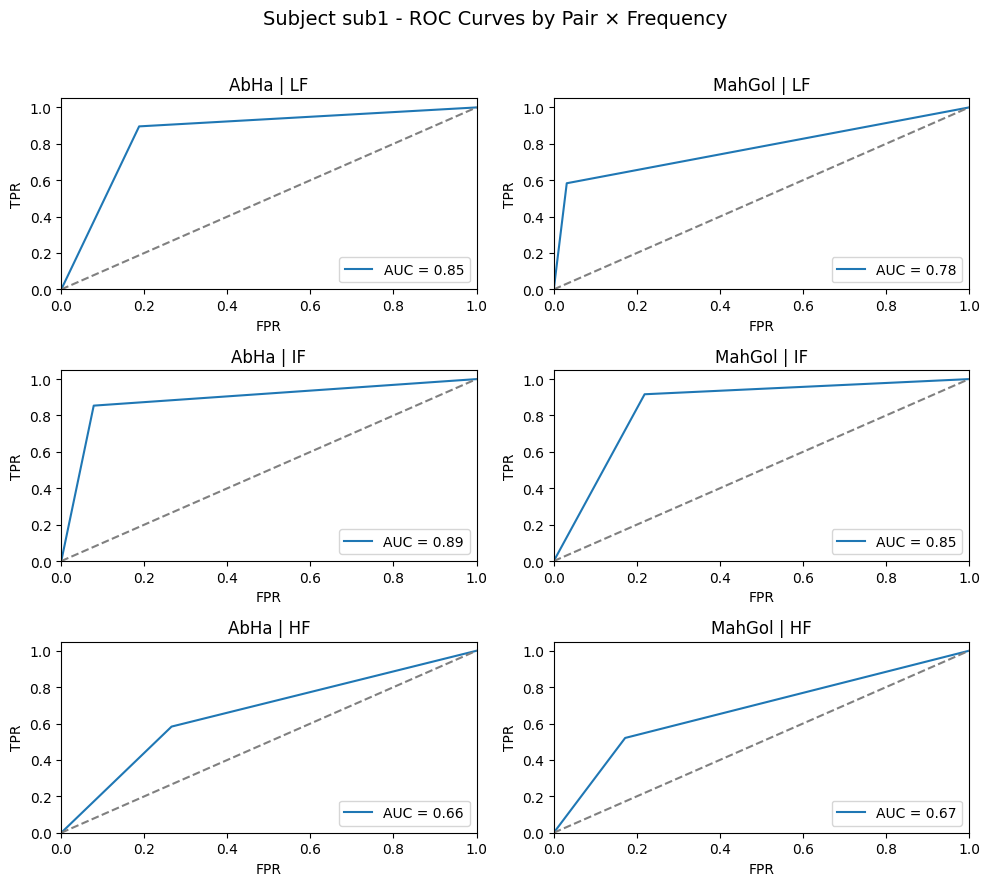

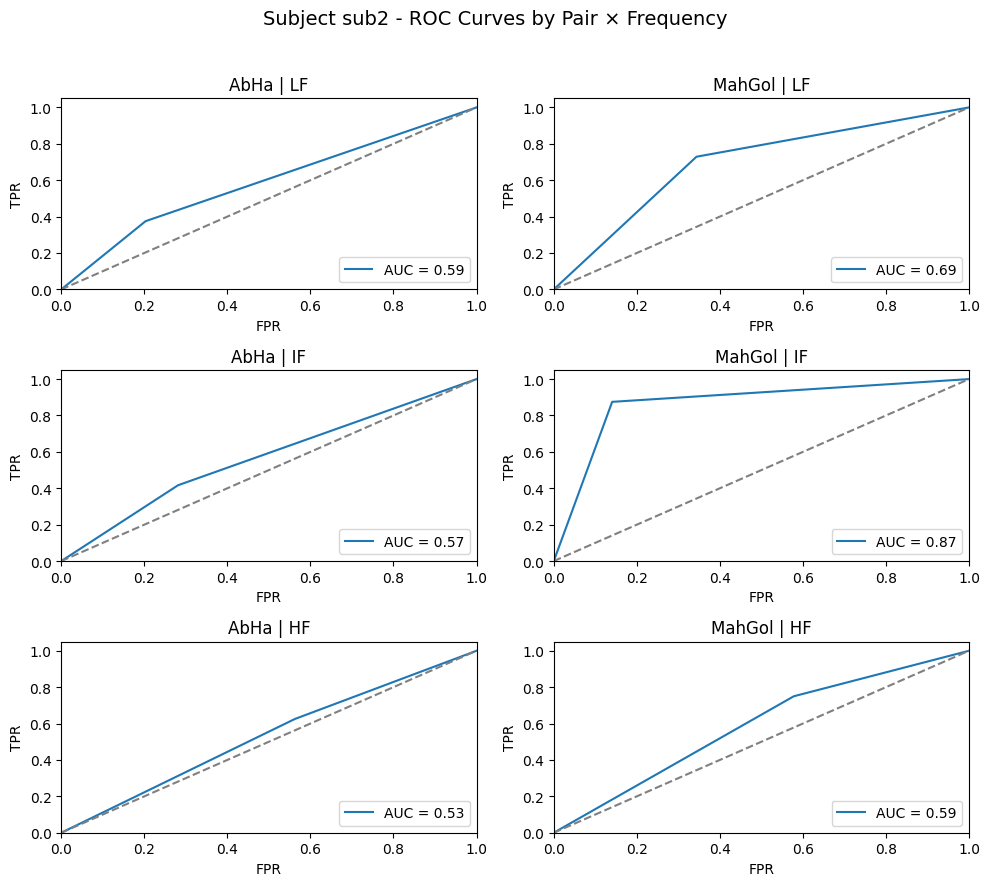

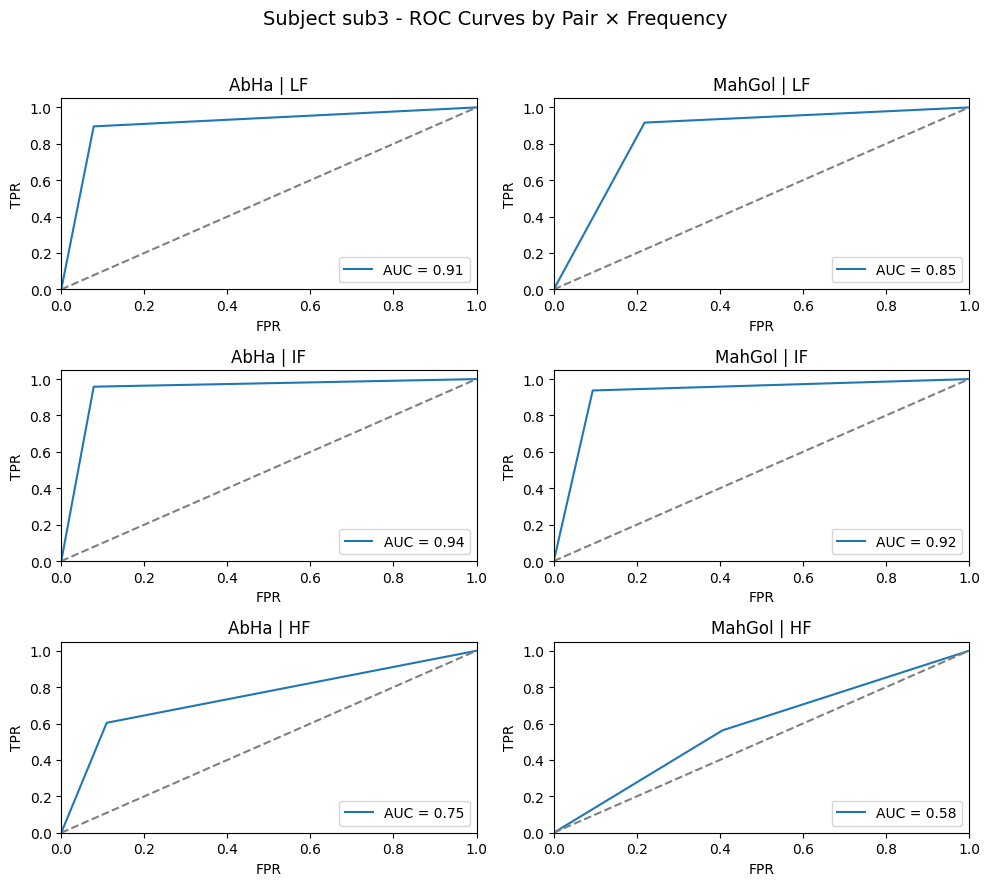

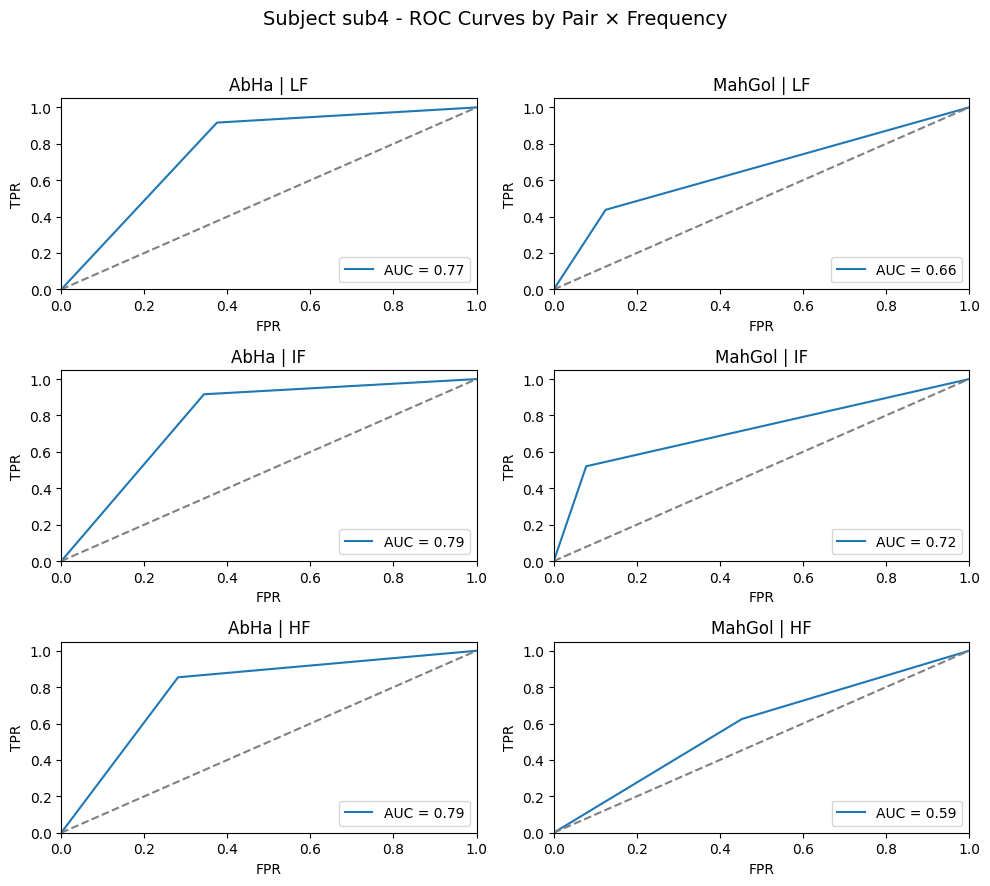

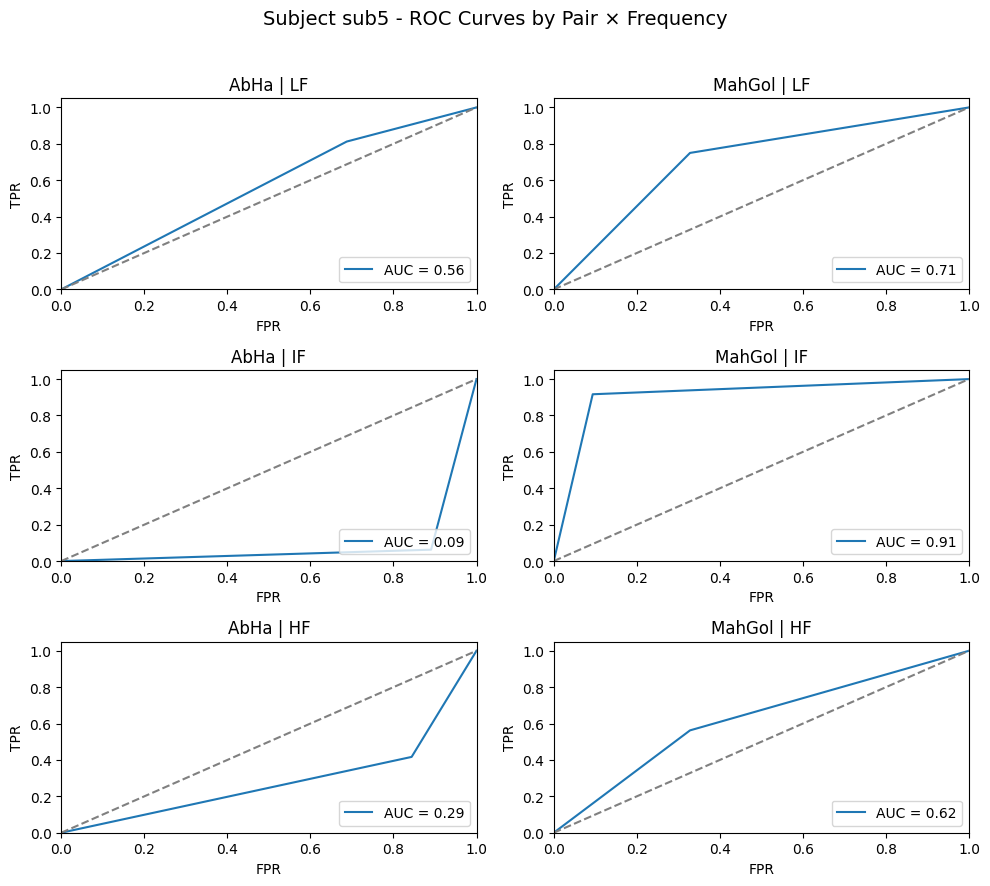

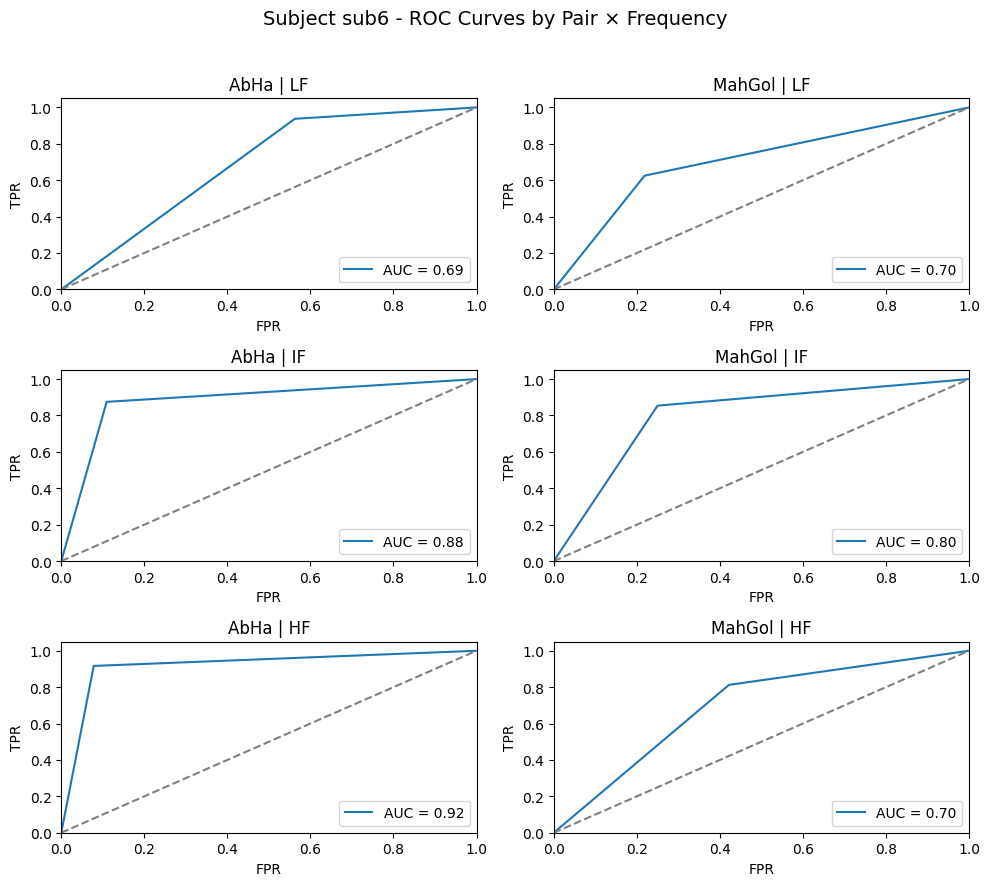

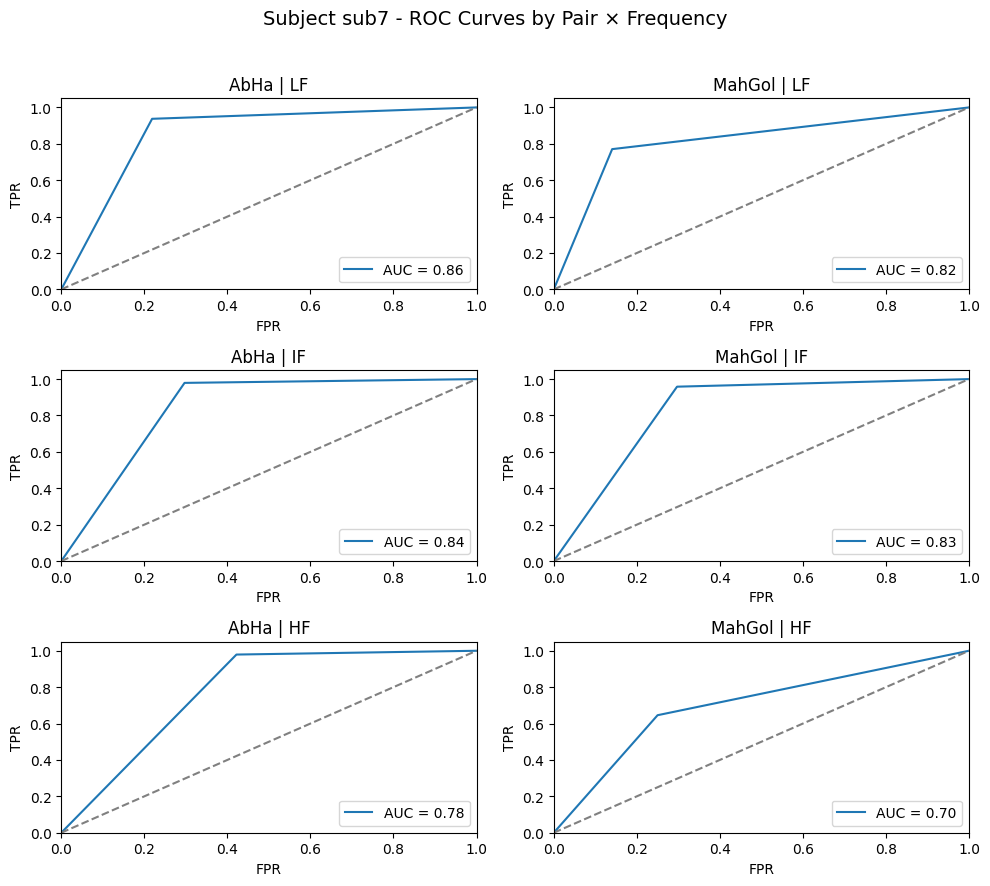

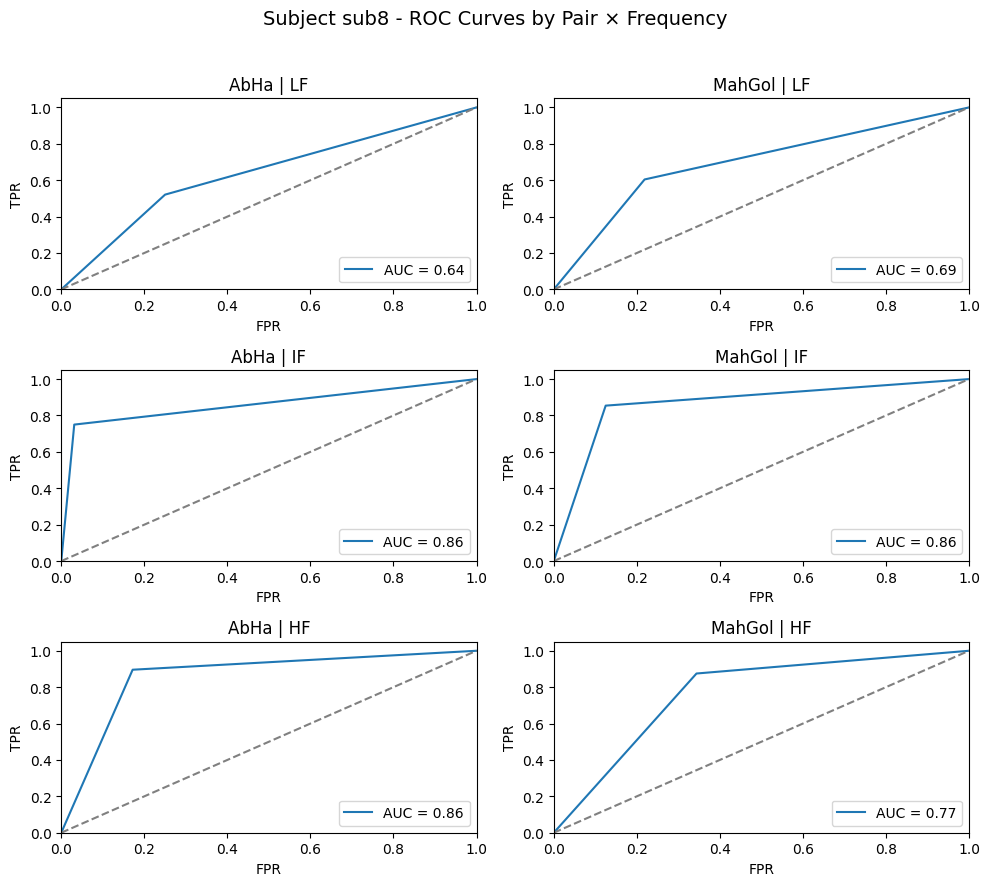

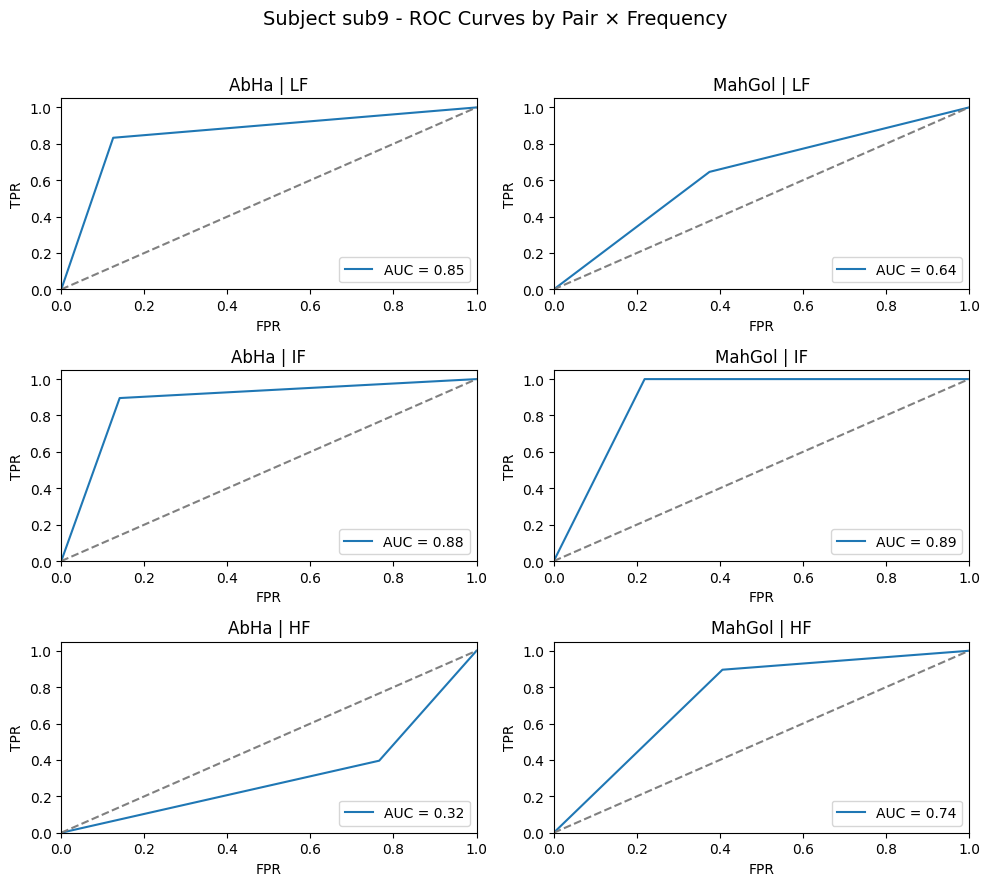

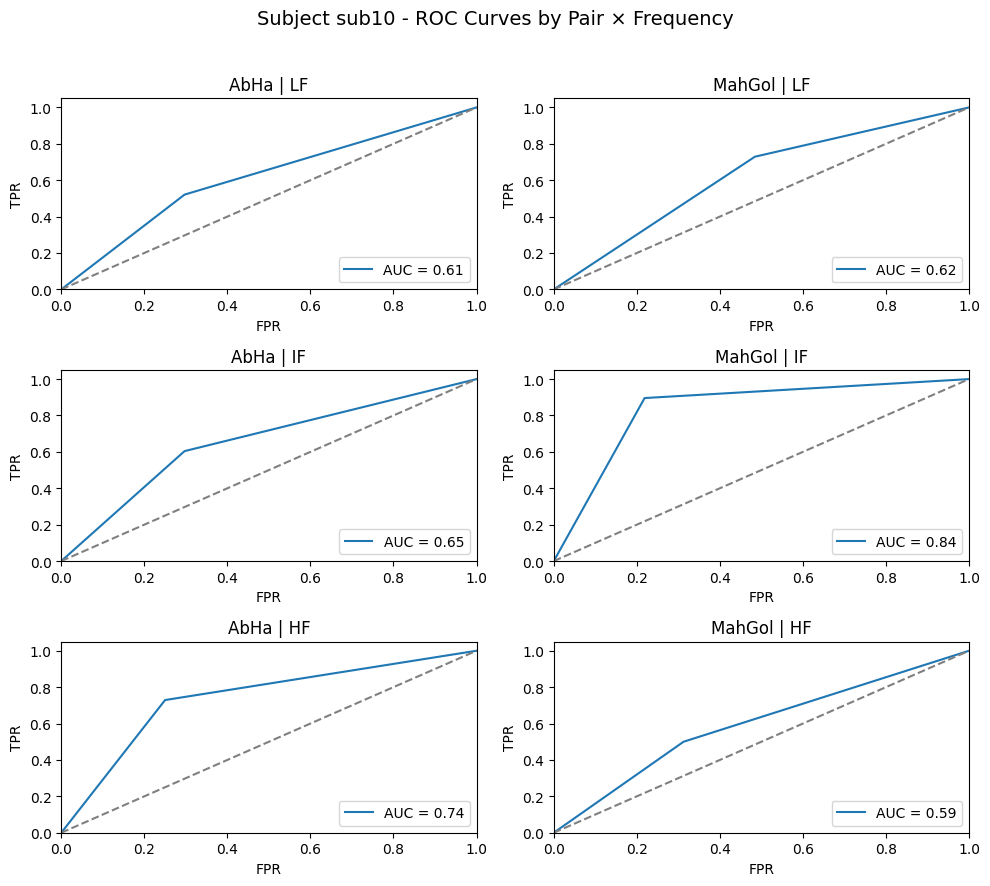

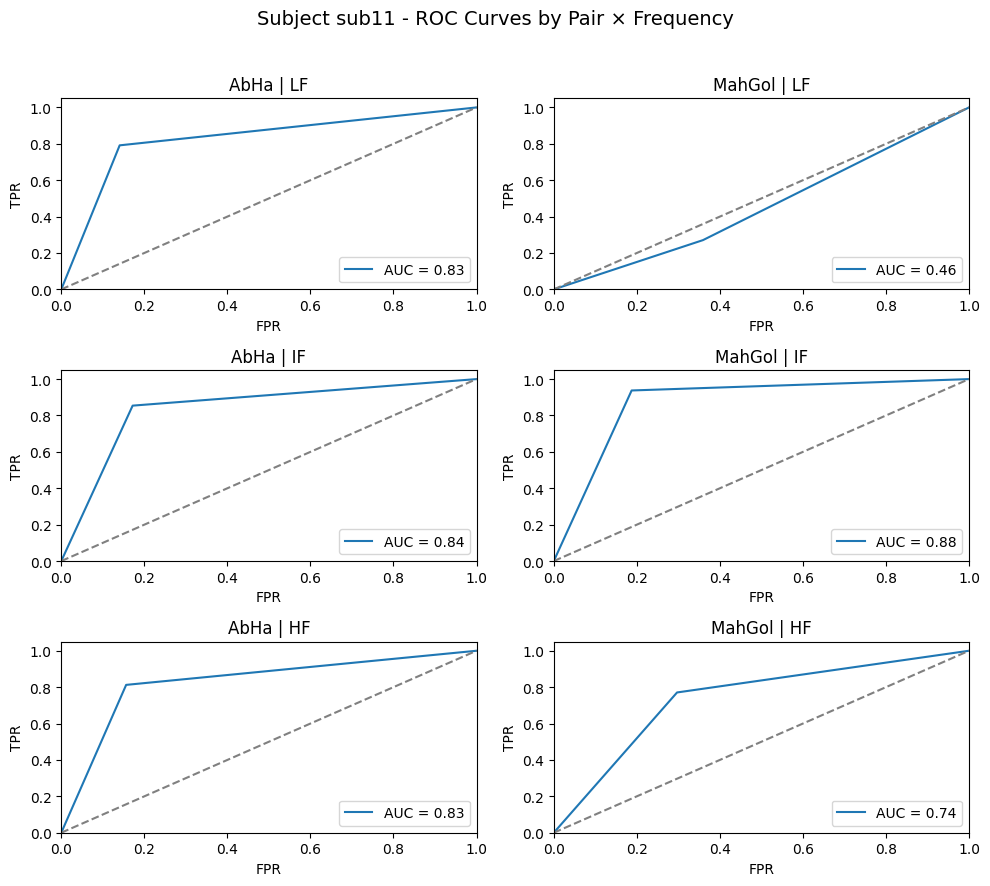

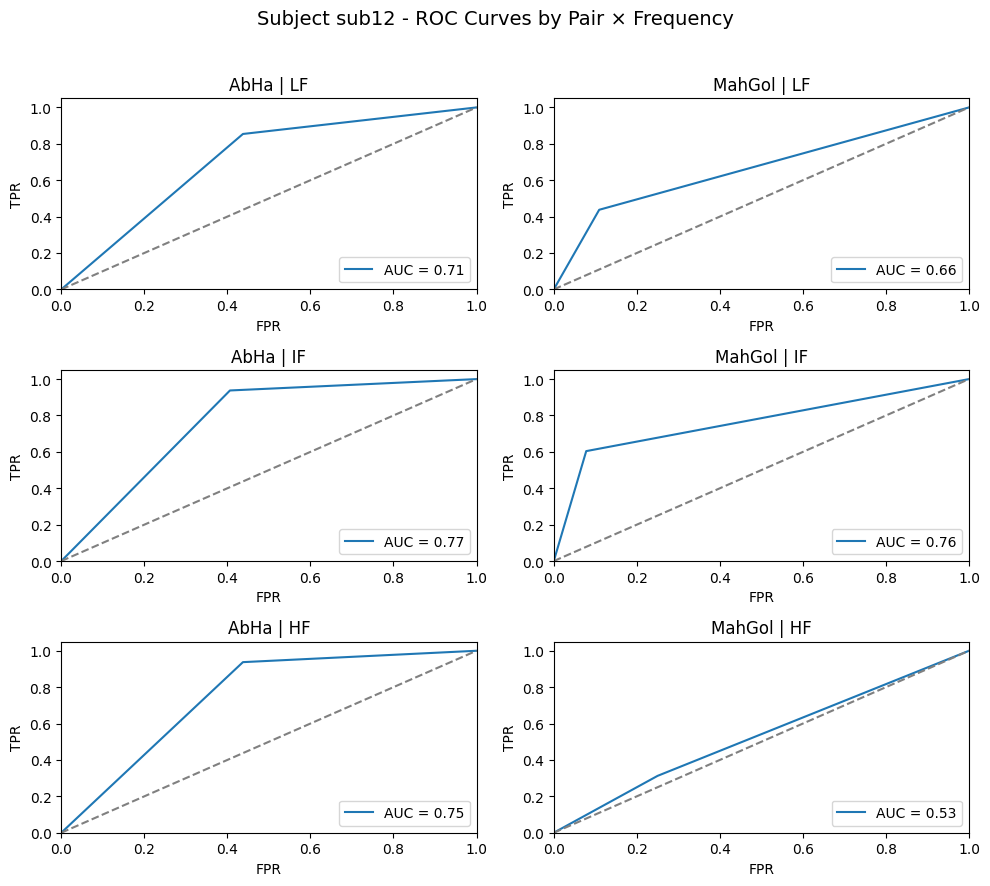

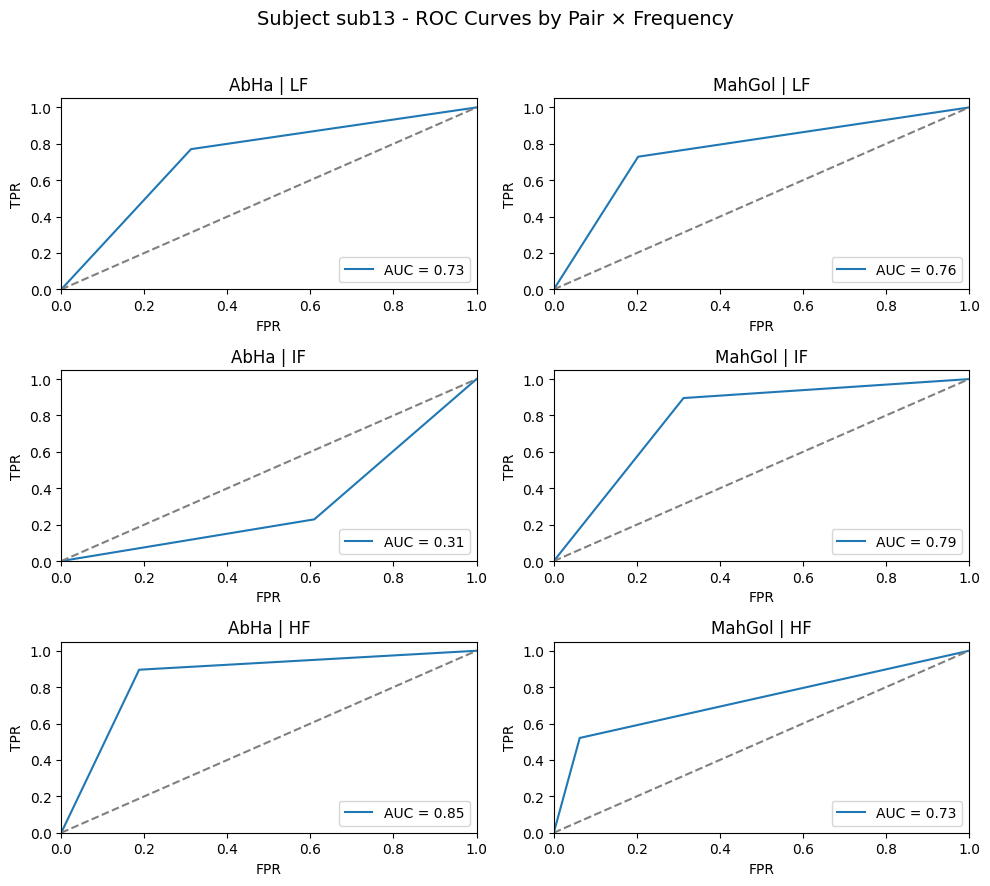

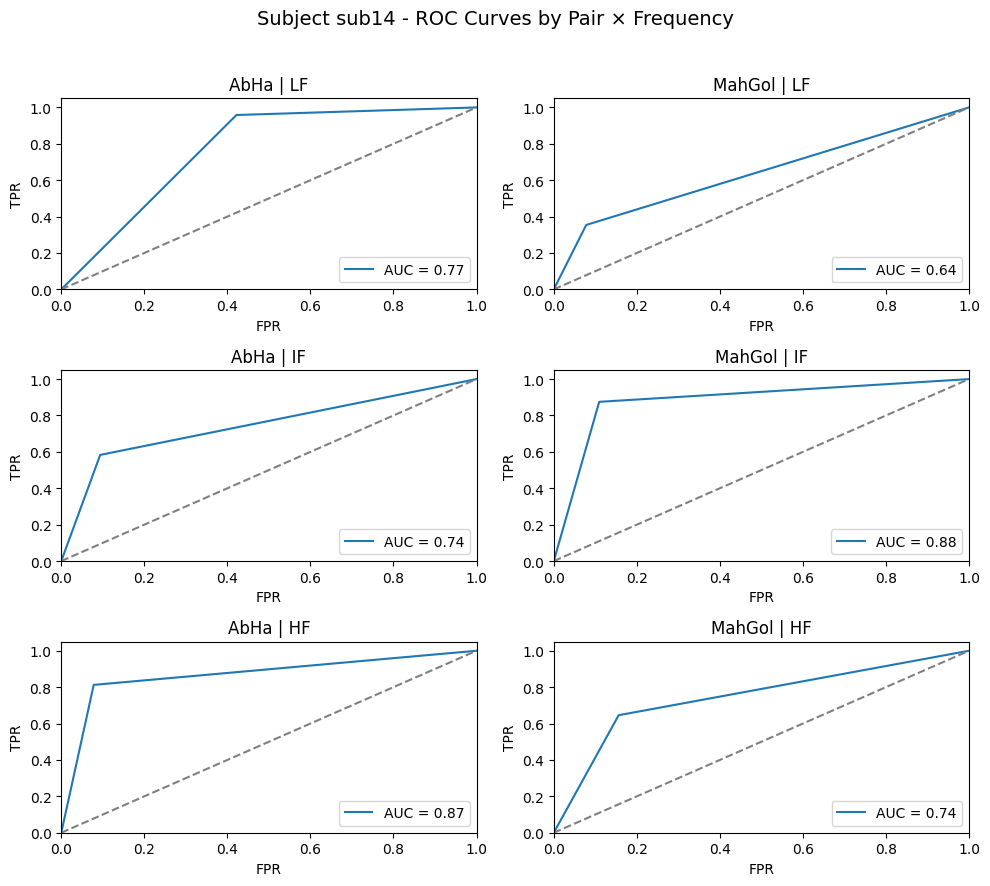

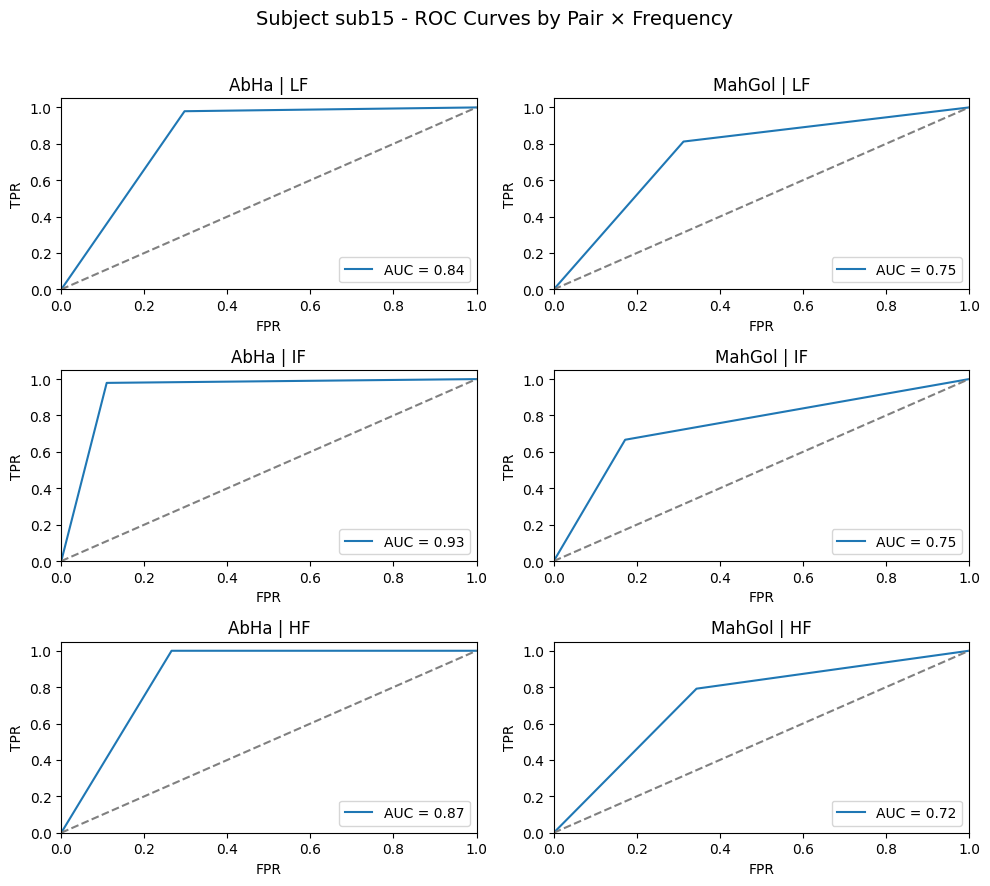

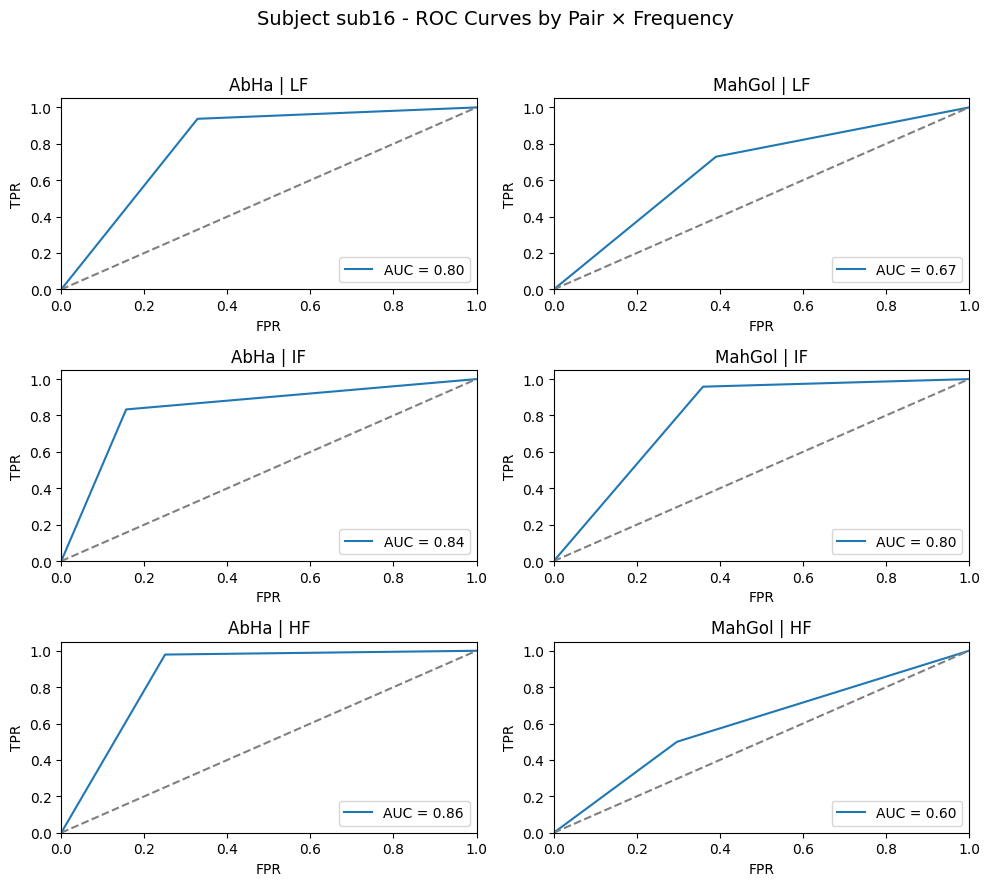

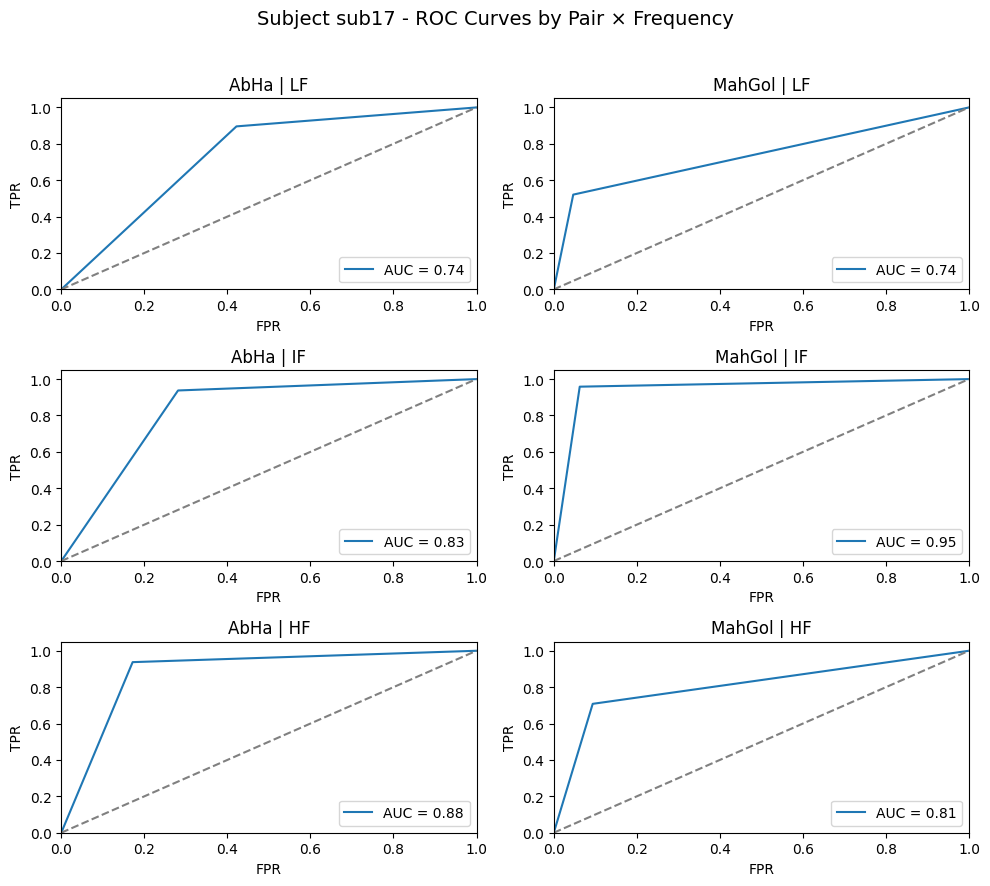

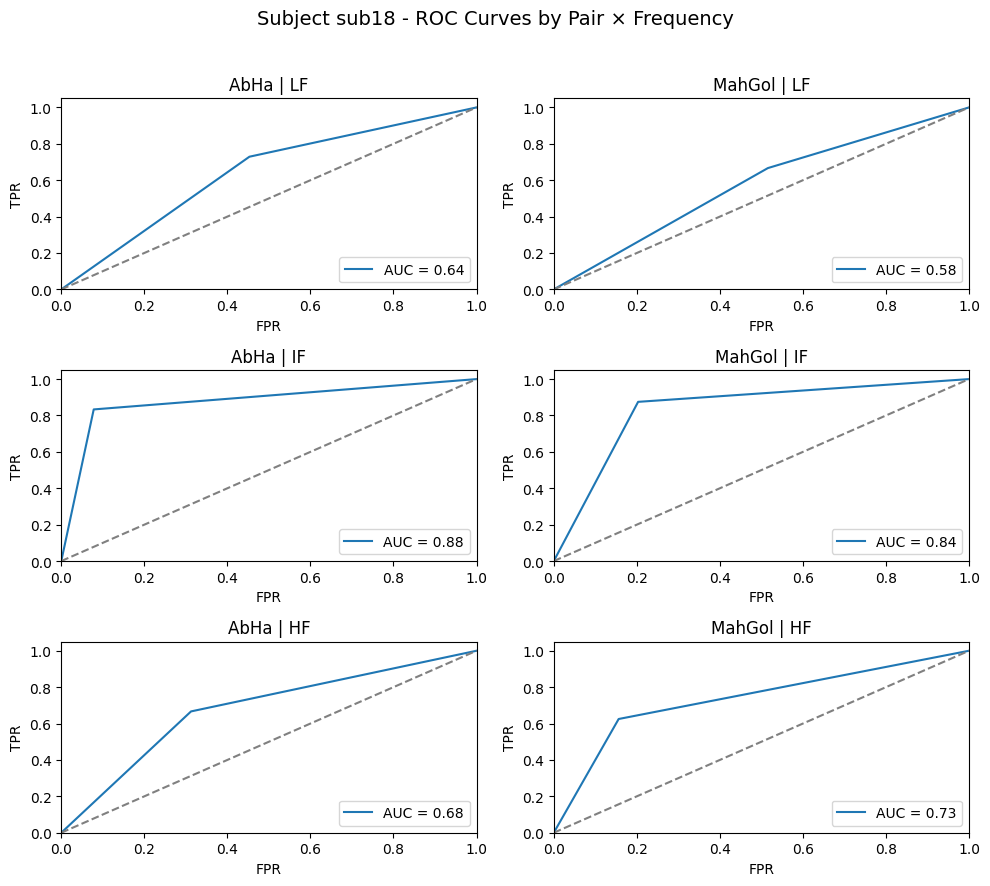

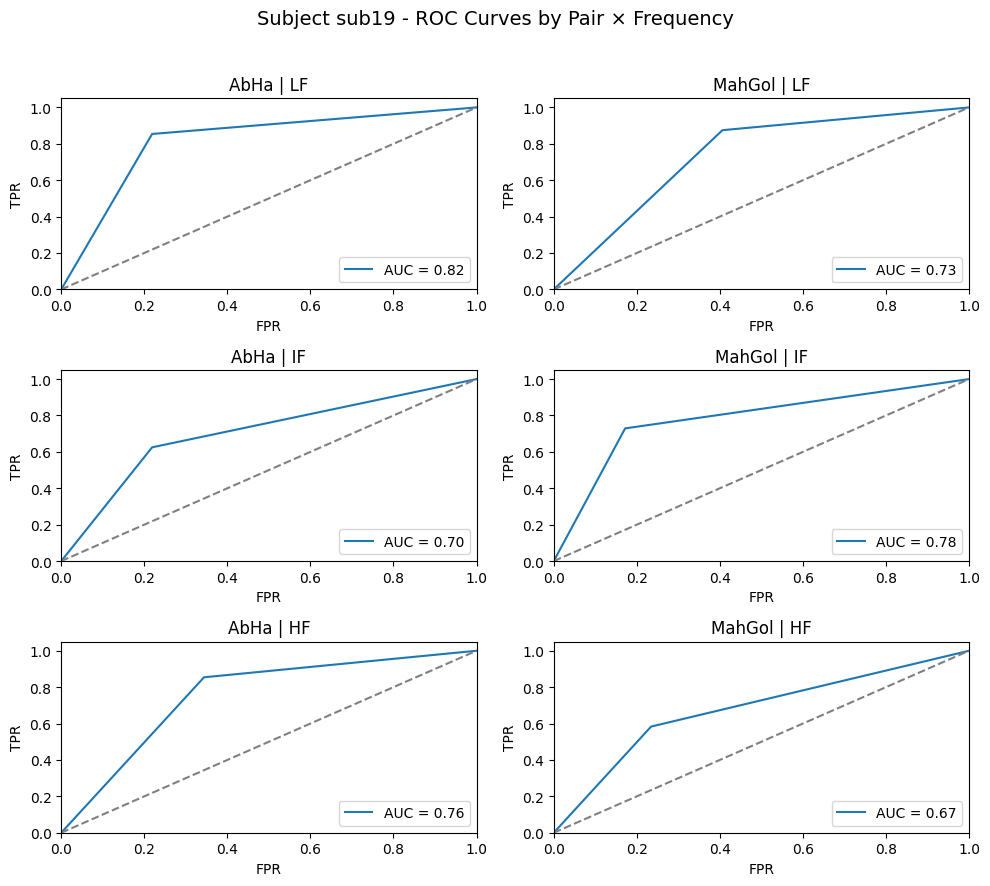

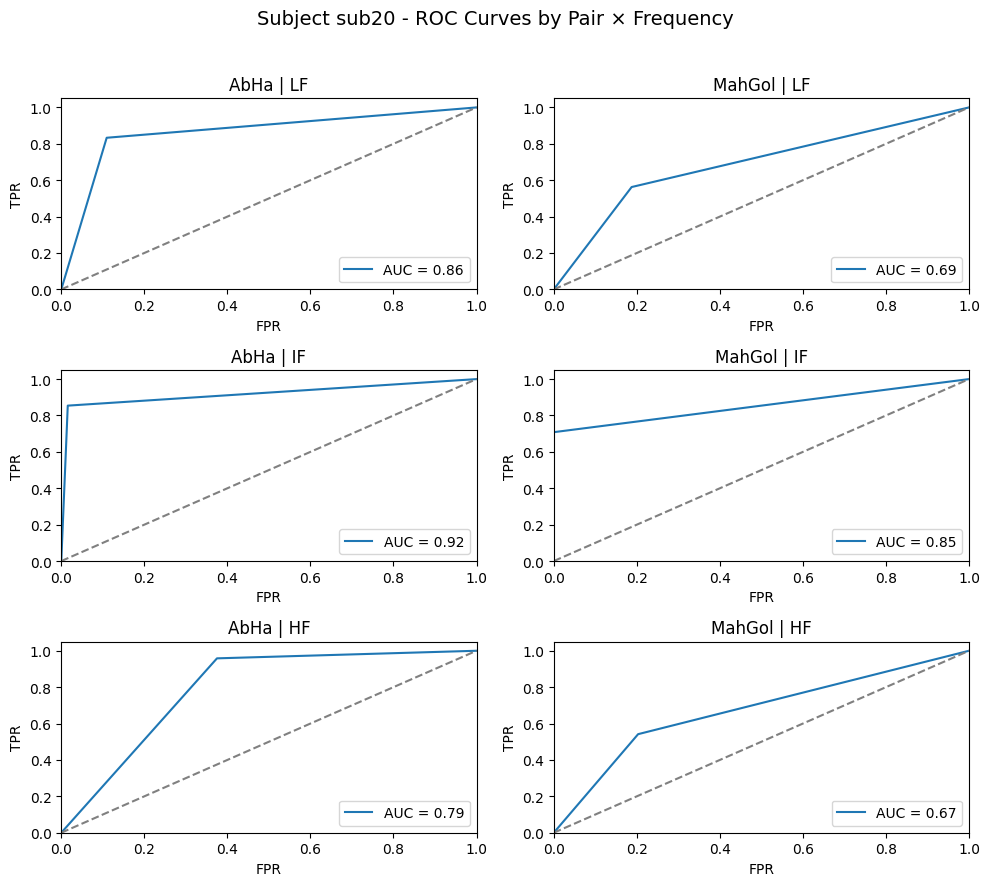

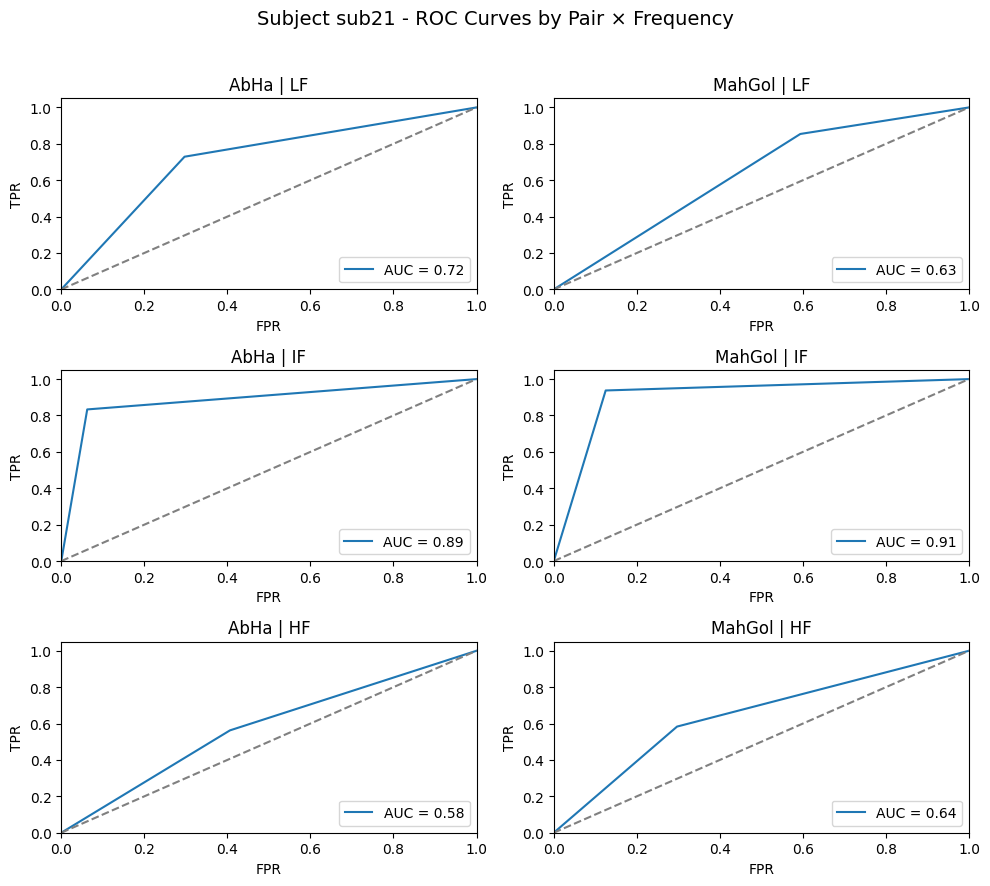

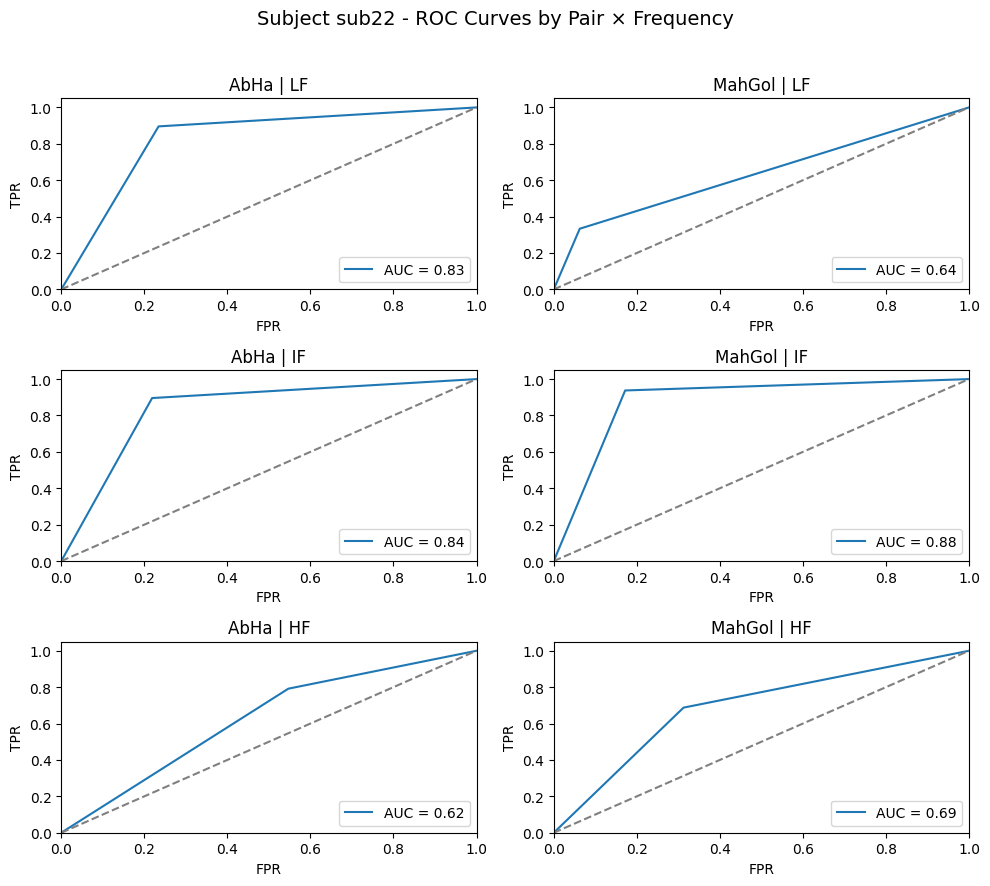

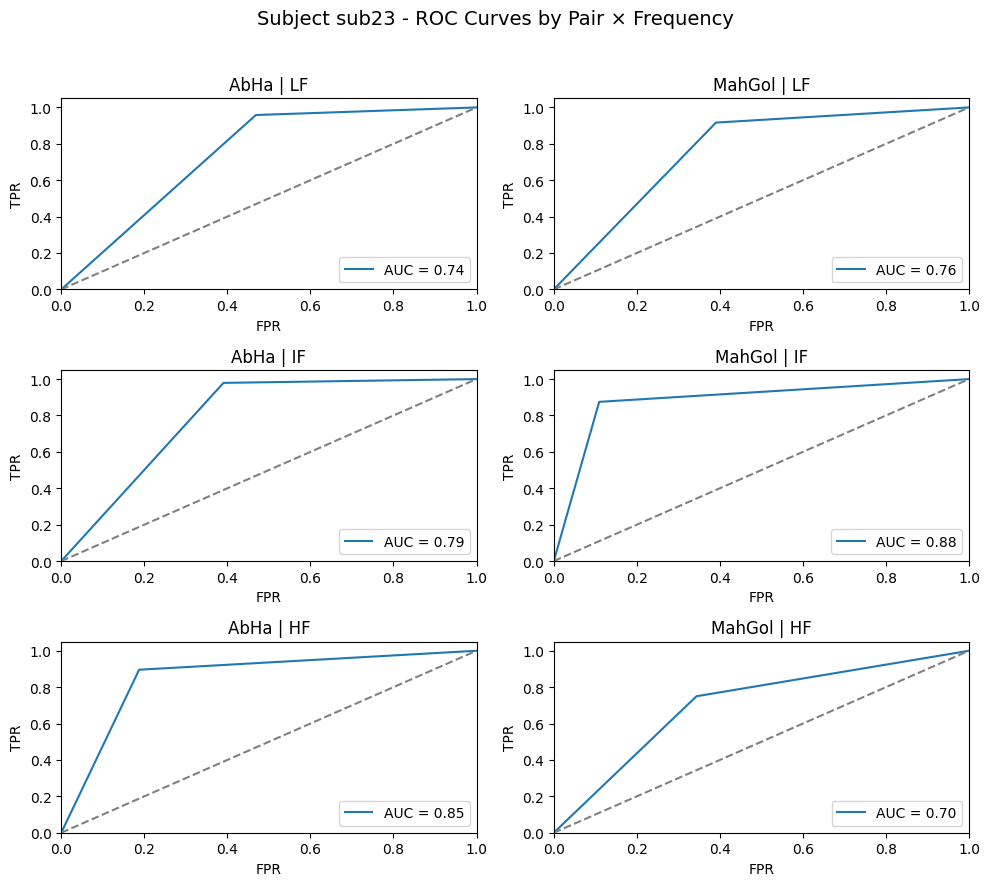

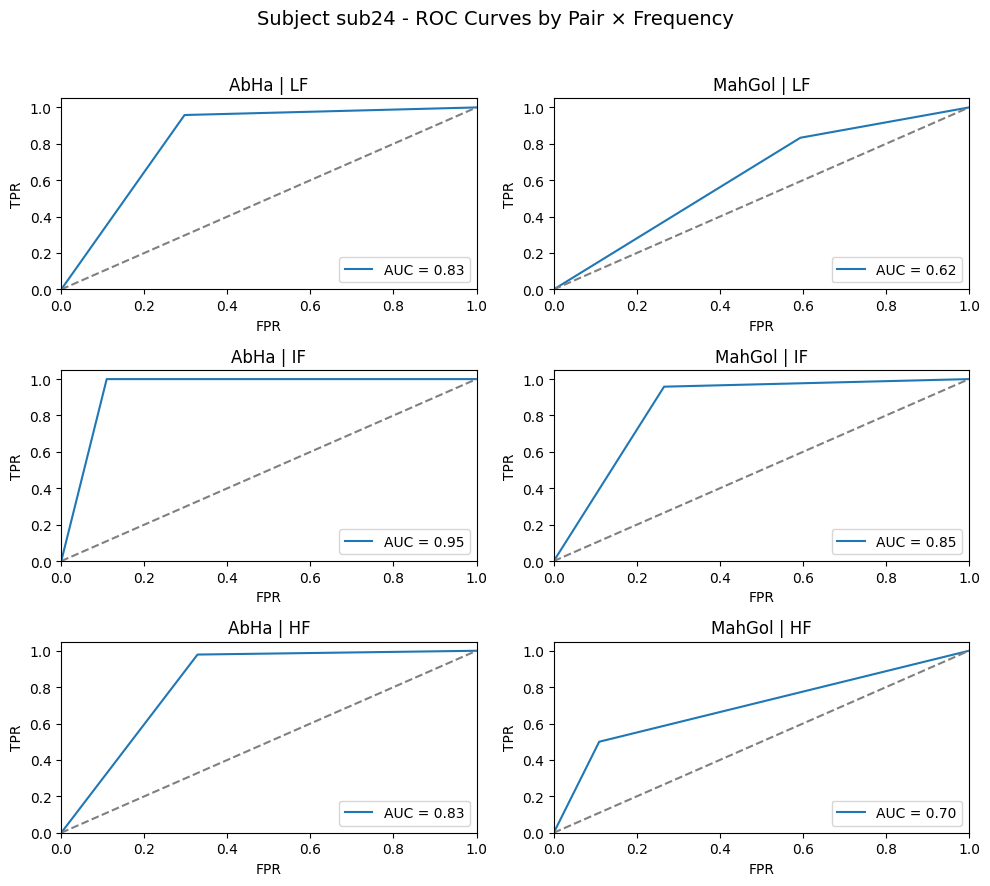

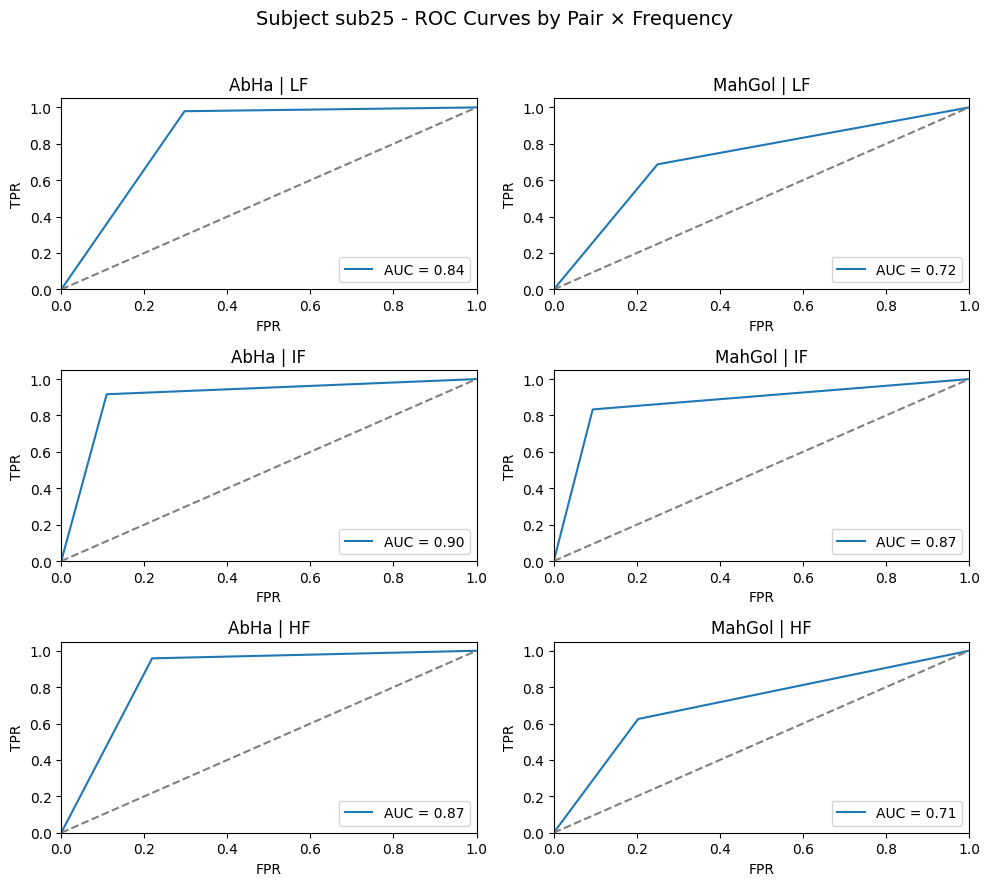

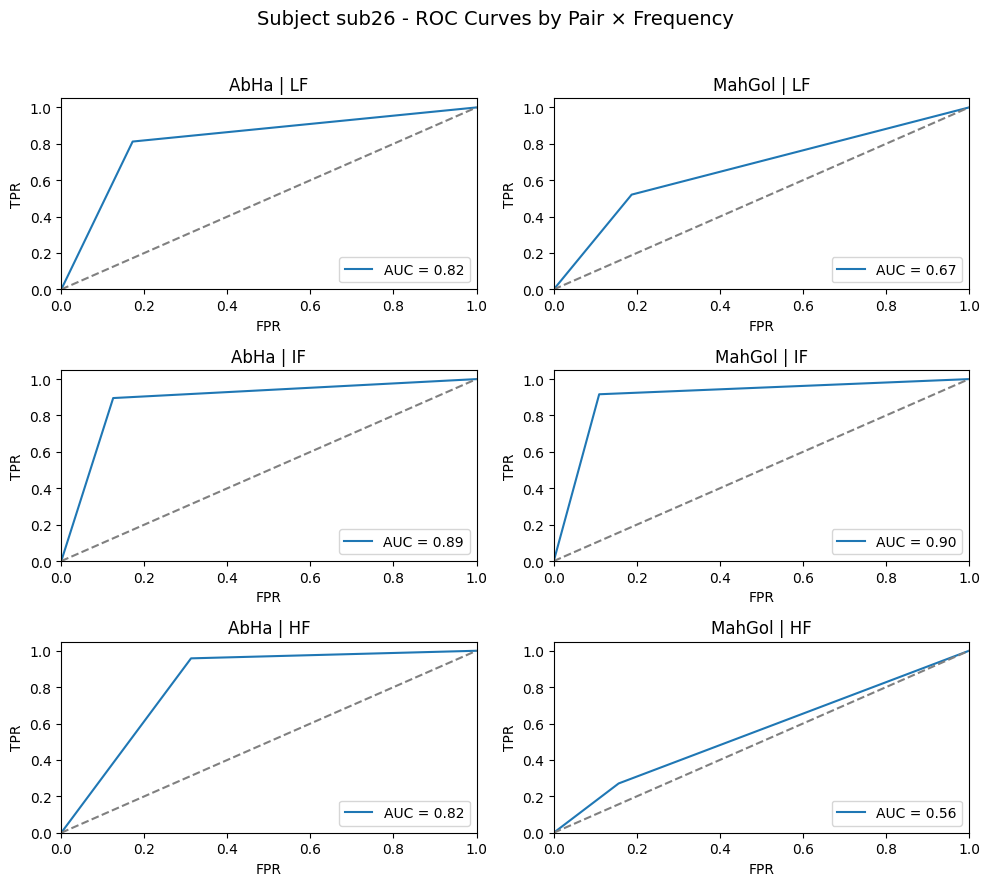

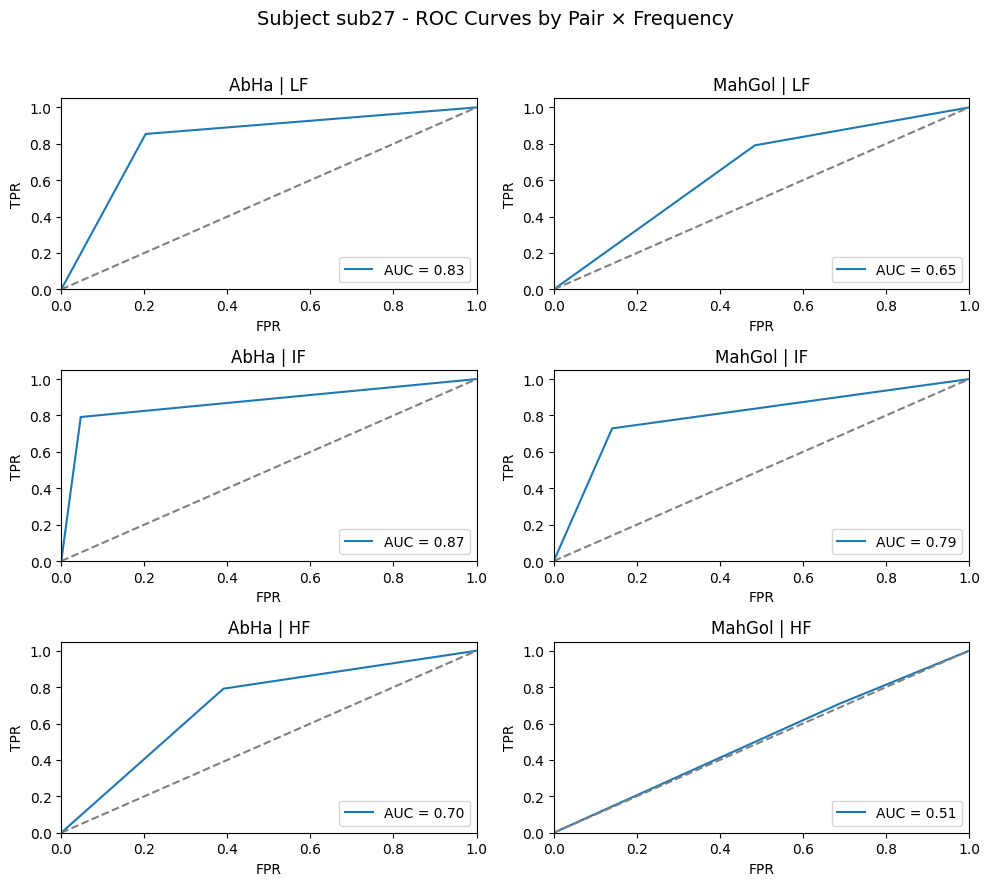

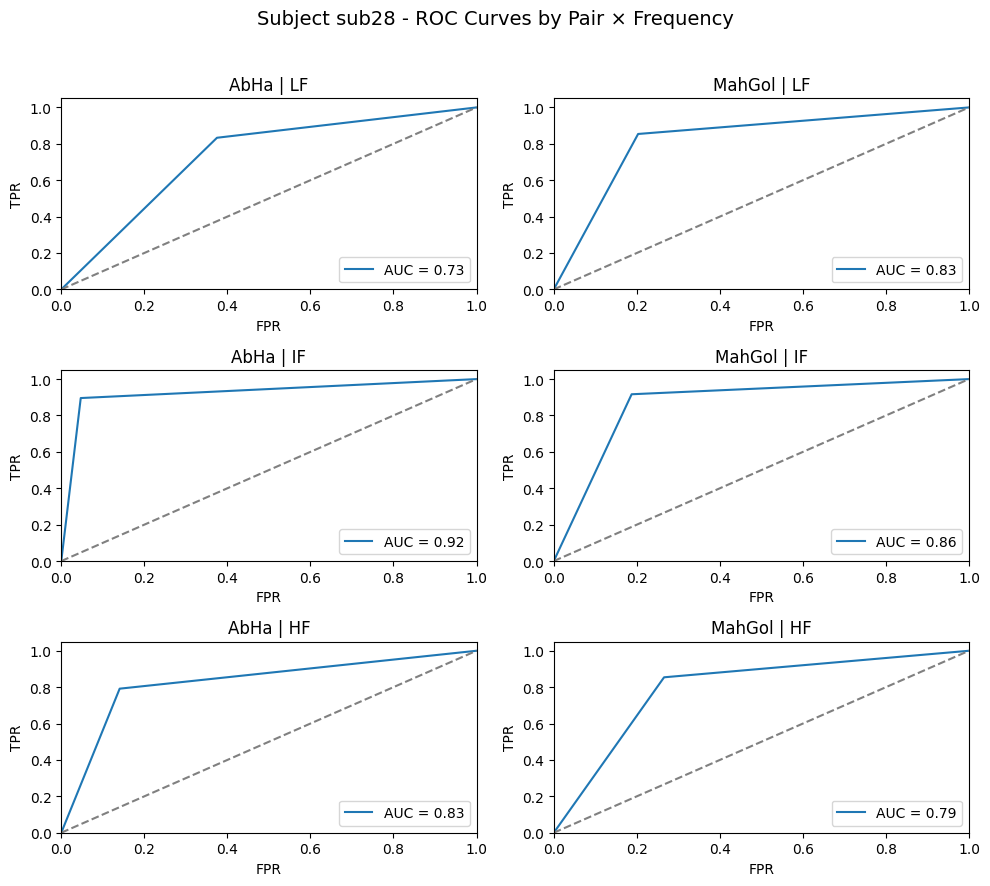

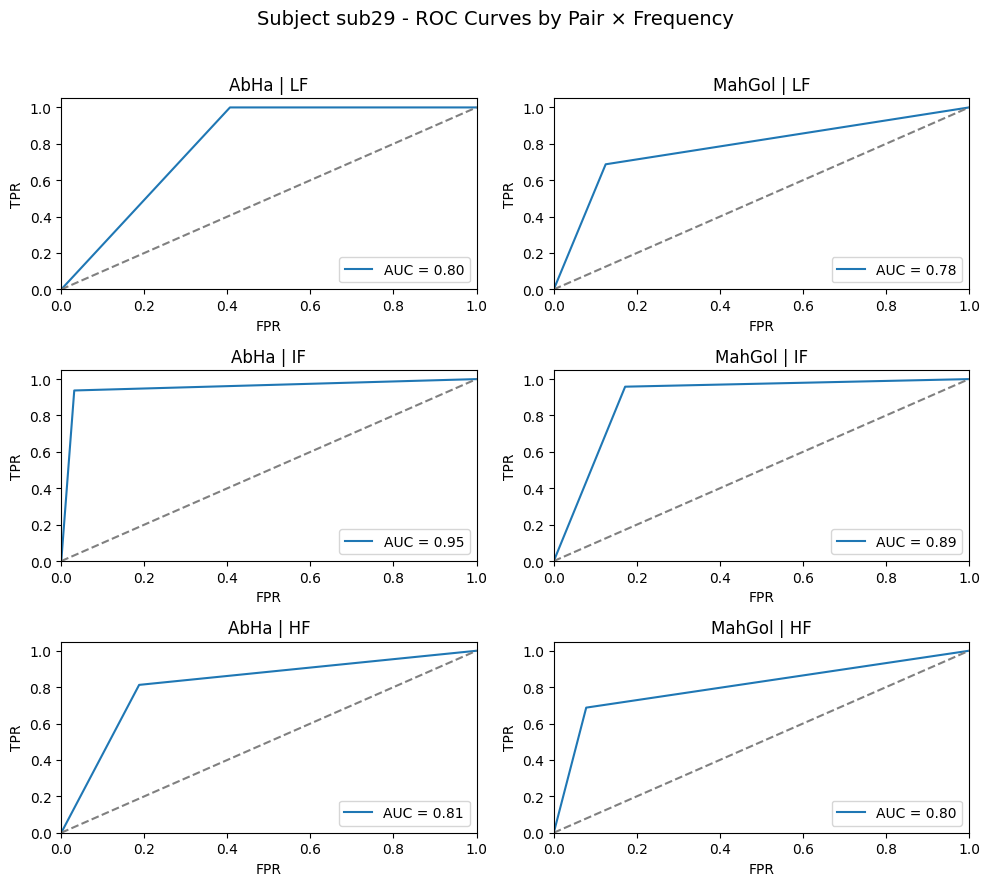

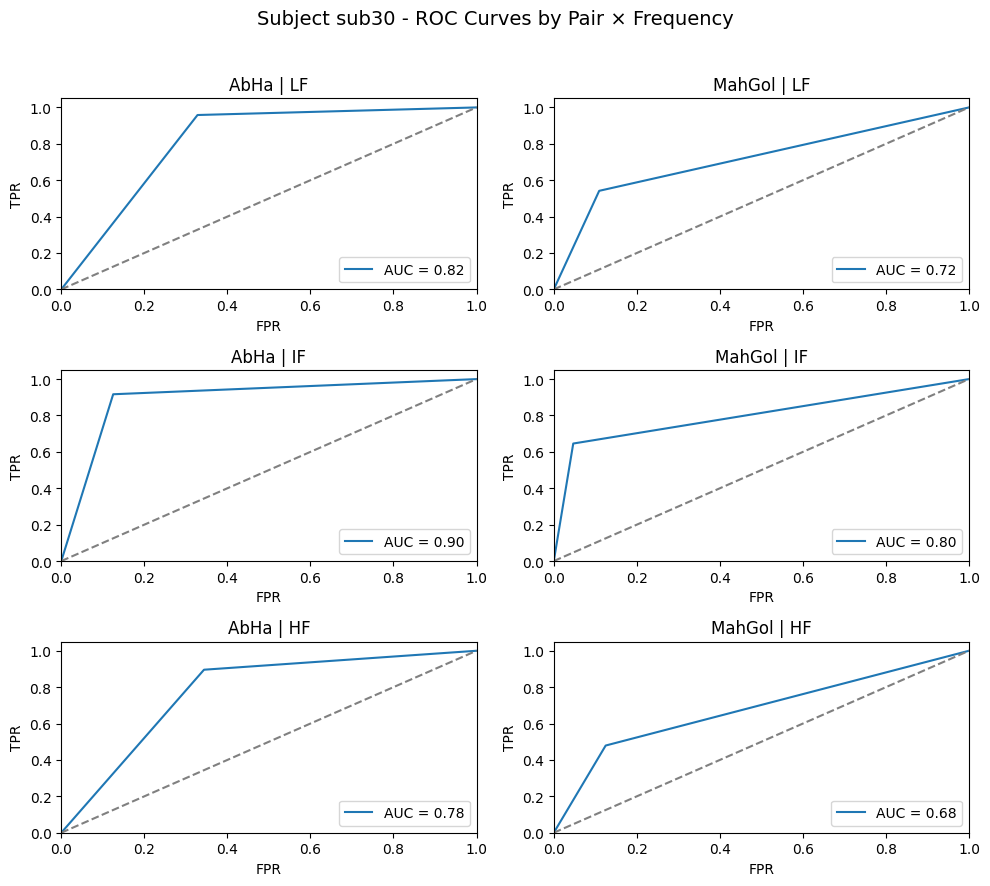

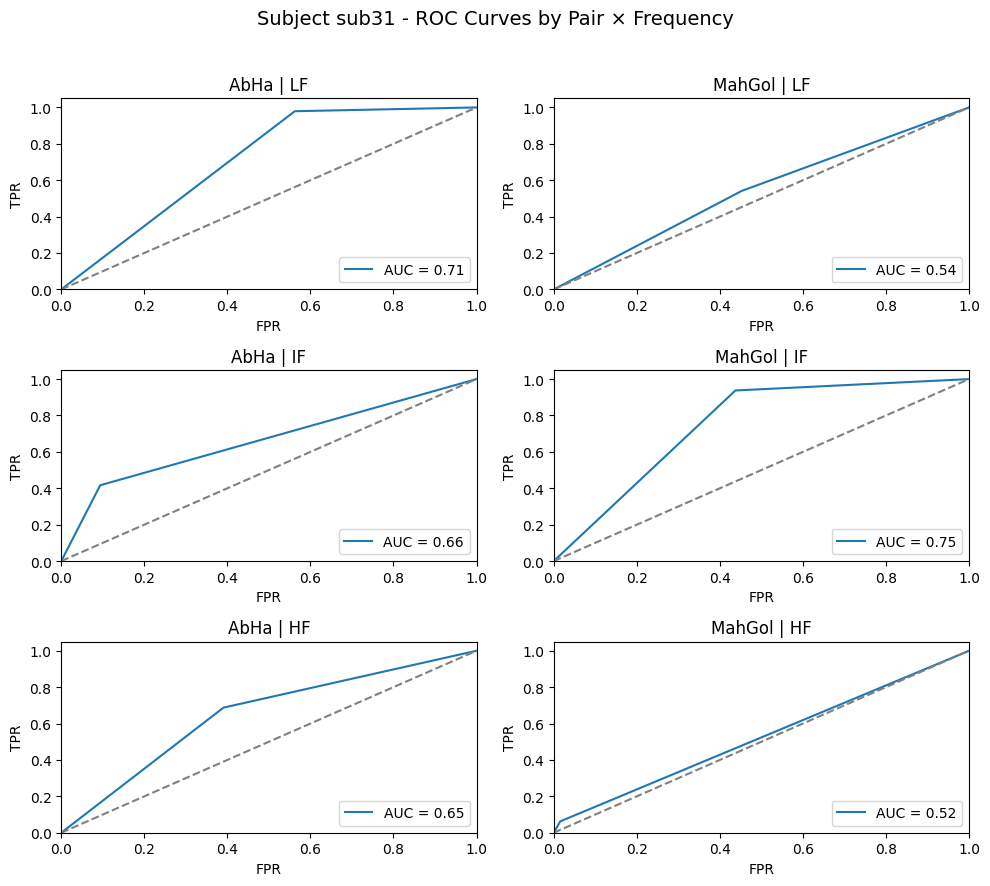

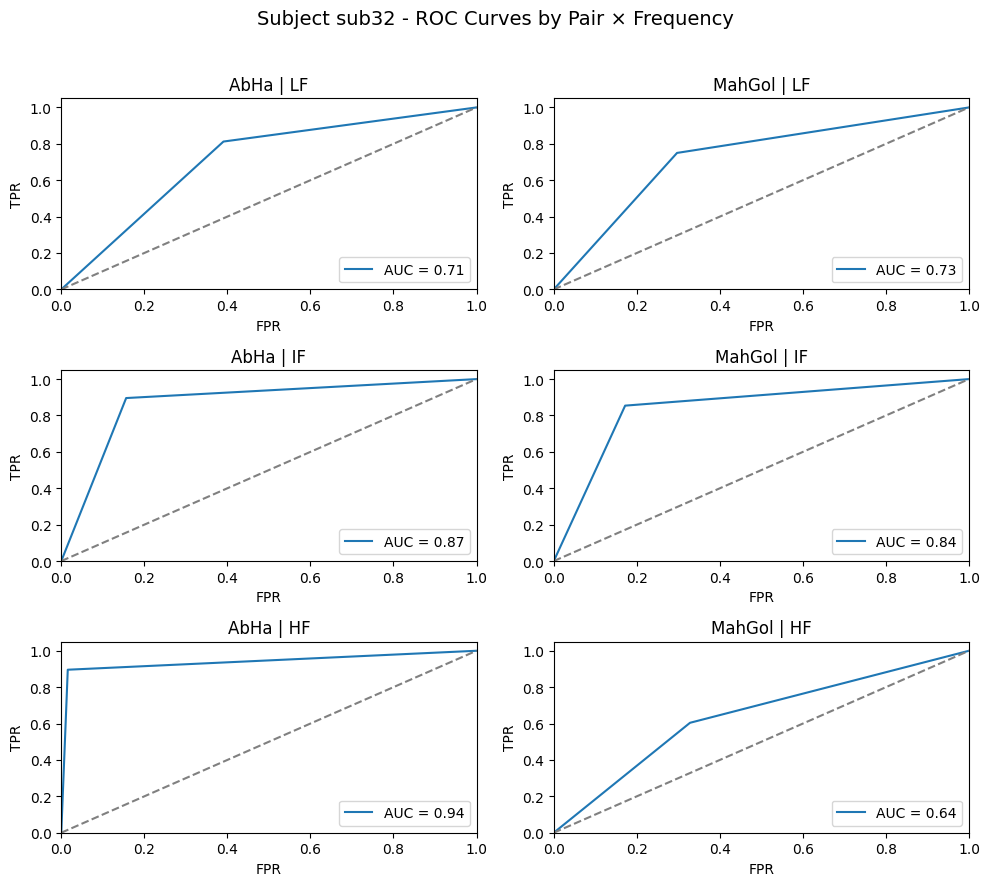

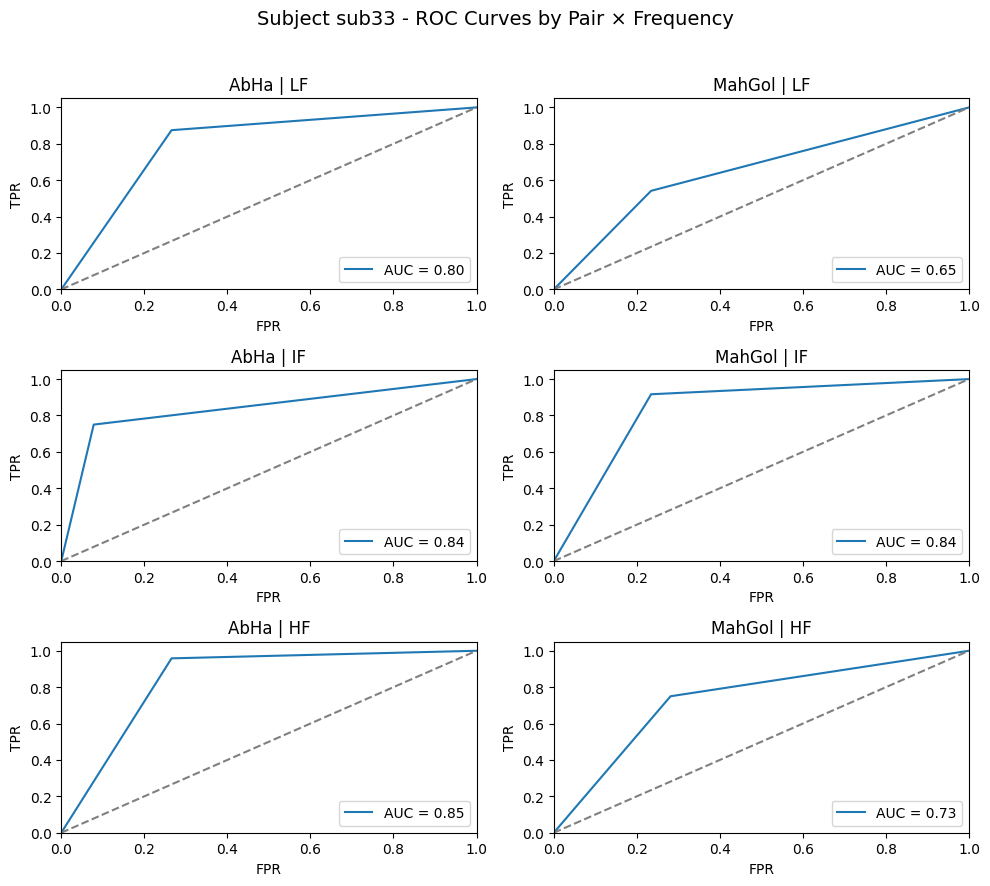

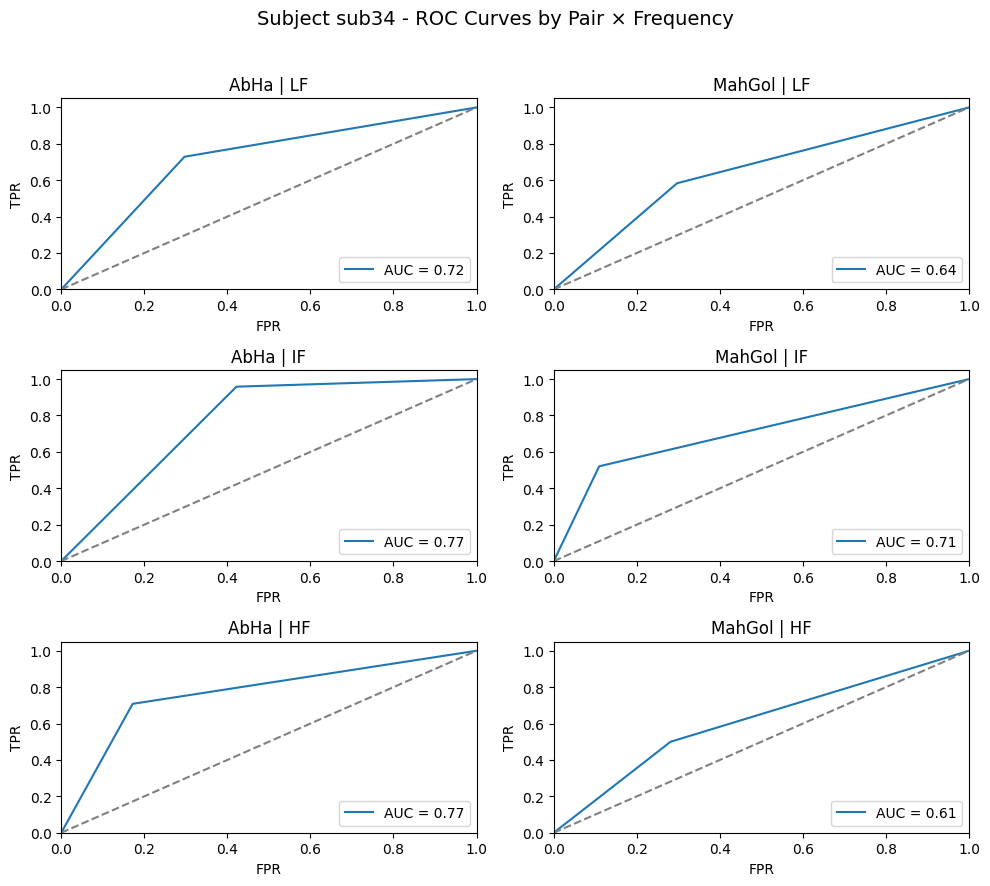

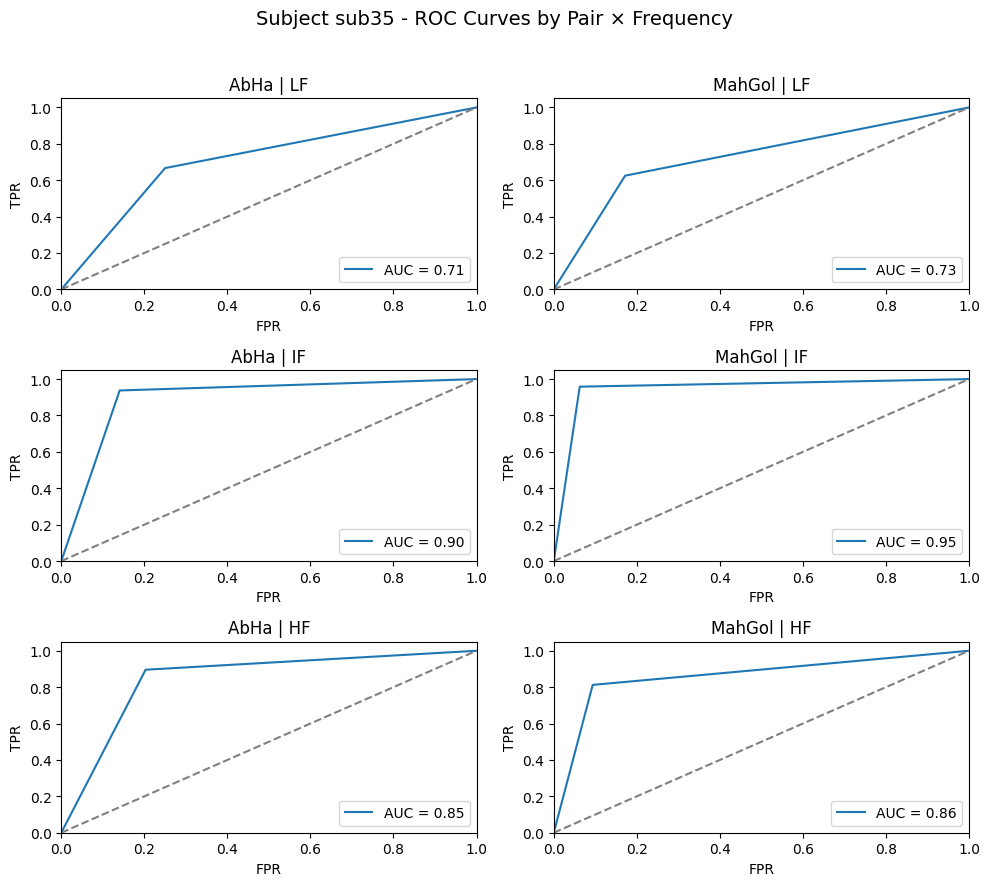

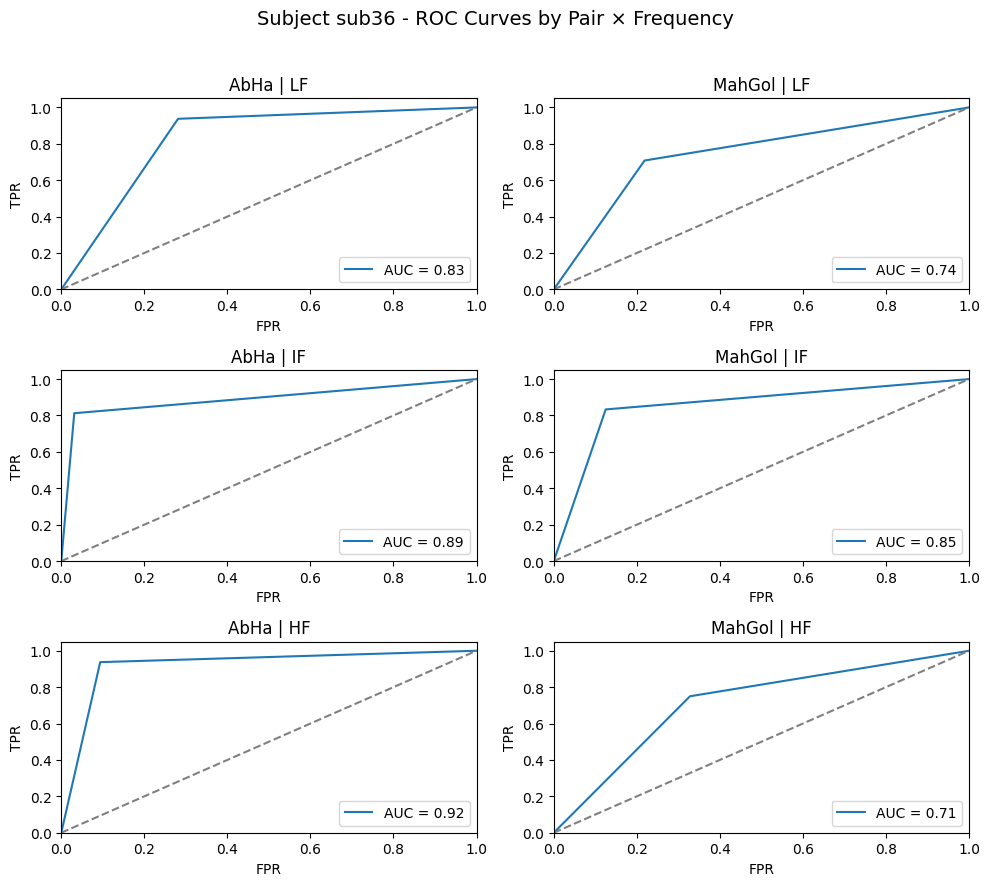

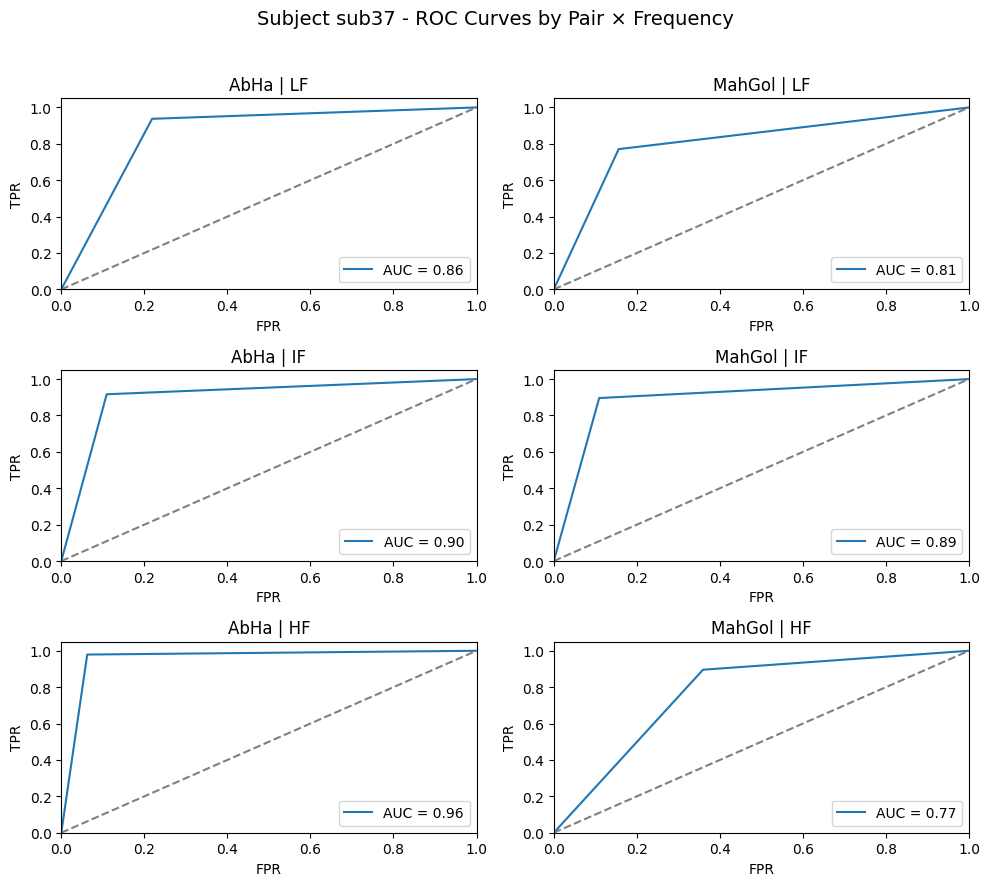

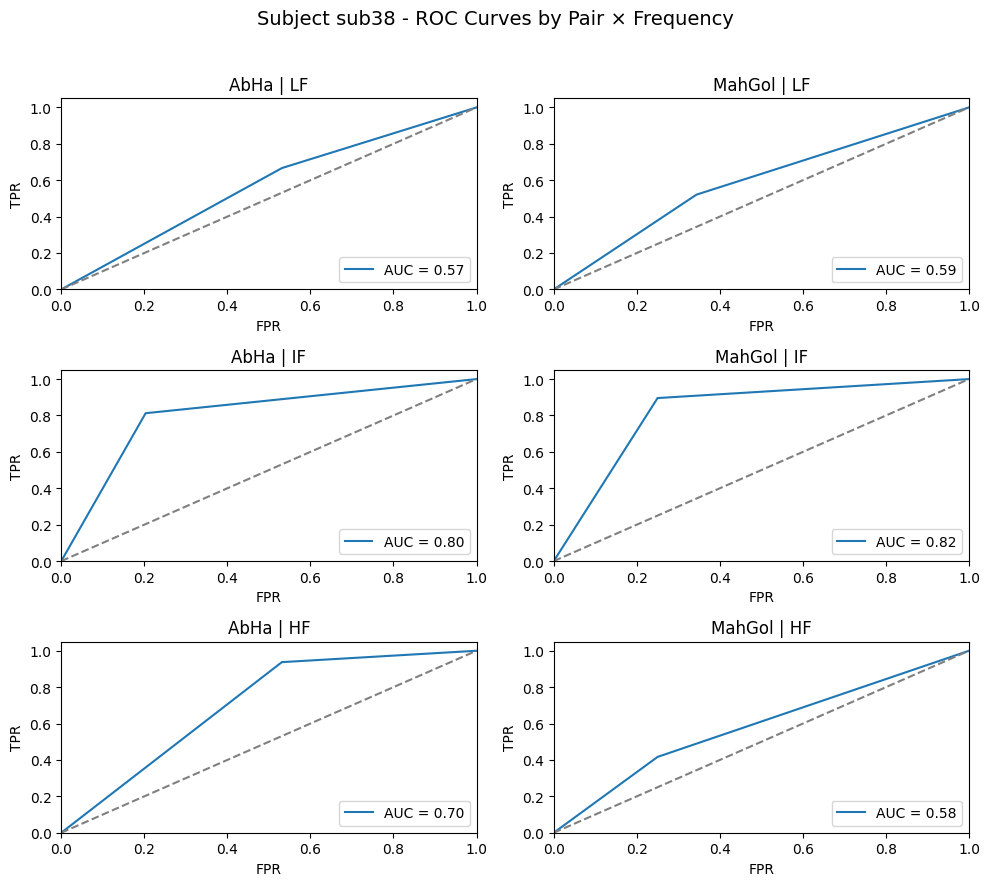

In [10]:
for i in range(1, len(subject)):
    subj_df = subject[i]
    subj_id = f"sub{i}"
    plot_subject_roc_grid(subj_df, subj_id)

In [11]:
abha = auc_df[['lf_abha', 'hf_abha', 'if_abha']]
mahgol = auc_df[['lf_mahgol', 'hf_mahgol', 'if_mahgol']]
stat_abha, pval_abha = friedmanchisquare(abha['lf_abha'], abha['hf_abha'], abha['if_abha'])
stat_mahgol, pval_mahgol = friedmanchisquare(mahgol['lf_mahgol'], mahgol['hf_mahgol'], mahgol['if_mahgol'])
print(f"ABHA Frequency Effect: p = {pval_abha:.4f}")
print(f"MAHGOL Frequency Effect: p = {pval_mahgol:.4f}")

ABHA Frequency Effect: p = 0.0007
MAHGOL Frequency Effect: p = 0.0000


C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_19348\4233741815.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=long, x='freq', y='auc', hue='pair', dodge=True, jitter=0.15, color='black', alpha=0.6)


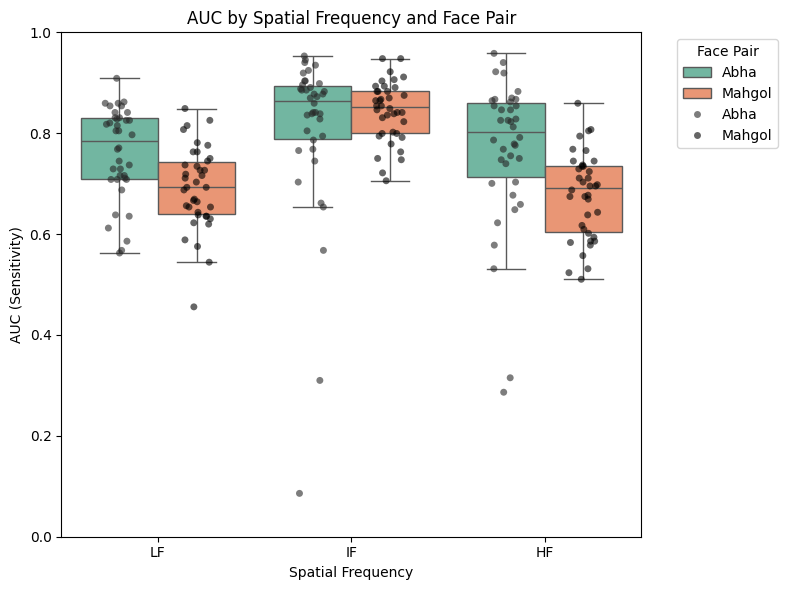

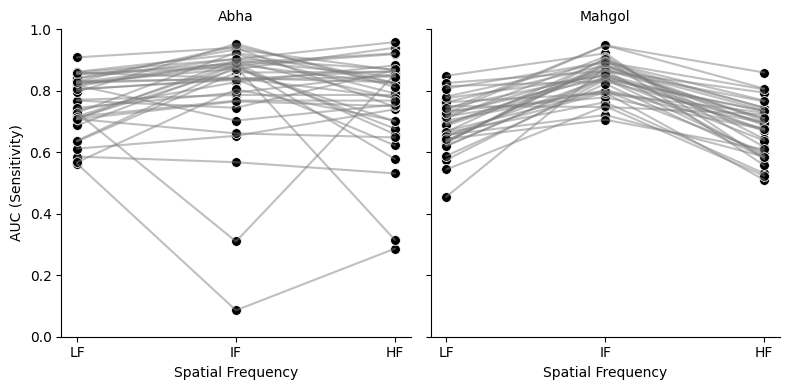

In [12]:
long = pd.melt(
    auc_df,
    id_vars=['subject_id', 'sex', 'dom'],
    value_vars=['lf_abha', 'if_abha', 'hf_abha', 'lf_mahgol', 'if_mahgol', 'hf_mahgol'],
    var_name='condition',
    value_name='auc'
)
long['pair'] = long['condition'].apply(lambda x: x.split('_')[1].capitalize())
long['freq'] = long['condition'].apply(lambda x: x.split('_')[0].upper())
long['freq'] = pd.Categorical(long['freq'], categories=['LF','IF','HF'], ordered=True)
plt.figure(figsize=(8, 6))
sns.boxplot(data=long, x='freq', y='auc', hue='pair', palette='Set2', showfliers=False)
sns.stripplot(data=long, x='freq', y='auc', hue='pair', dodge=True, jitter=0.15, color='black', alpha=0.6)
plt.title('AUC by Spatial Frequency and Face Pair')
plt.ylabel('AUC (Sensitivity)')
plt.xlabel('Spatial Frequency')
plt.ylim(0, 1)
plt.legend(title='Face Pair', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
g = sns.FacetGrid(long, col='pair', height=4, aspect=1, sharey=True)
g.map_dataframe(sns.lineplot, x='freq', y='auc', units='subject_id', estimator=None, color='gray', alpha=0.5)
g.map_dataframe(sns.scatterplot, x='freq', y='auc', color='black', s=50)
g.set_axis_labels('Spatial Frequency', 'AUC (Sensitivity)')
g.set_titles('{col_name}')
for ax in g.axes.flat:
    ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

Second hypo:

In [13]:
def compute_auc_allfreq(data, pair):
    df = data[
        (data['trialKeys'] == pair) &
        (data['blockType'] == 'same')
    ]
    if pair == 'AbHa':
        label_col = df['levelFace'].apply(lambda x: 1 if x > 0 else 0)
        resp_col = df['srespChoice'].apply(lambda x: 1 if x == 'Hasan' else 0)
    elif pair == 'MahGol':
        label_col = df['levelFace'].apply(lambda x: 1 if x > 0 else 0)
        resp_col = df['srespChoice'].apply(lambda x: 1 if x == 'Goli' else 0)
    else:
        return np.nan
    if len(set(label_col)) < 2 or len(set(resp_col)) < 2:
        return np.nan
    try:
        auc = roc_auc_score(label_col, resp_col)
        return auc
    except:
        return np.nan

In [14]:
results = []
for i in range(1, len(subject)):
    subj_data = subject[i]
    if subj_data is None:
        continue
    subj_info = sub_info.iloc[i - 1]
    abha_auc = compute_auc_allfreq(subj_data, 'AbHa')
    mahgol_auc = compute_auc_allfreq(subj_data, 'MahGol')
    results.append({
        'subject_id': f"sub{i}",
        'sex': subj_info['sex'],
        'abha_auc': abha_auc,
        'mahgol_auc': mahgol_auc
    })
auc1 = pd.DataFrame(results)
auc1.head()

subject_id sex  abha_auc  mahgol_auc
0       sub1   M  0.800347    0.766493
1       sub2   M  0.561632    0.715278
2       sub3   M  0.865451    0.782986
3       sub4   M  0.781250    0.654514
4       sub5   M  0.311632    0.746528

In [15]:
male_1 = auc1[auc1['sex'] == 'M']
male_p = wilcoxon(male_1['abha_auc'], male_1['mahgol_auc'])
print("P value for male: ",male_p.pvalue)

P value for male:  0.1593780517578125


In [16]:
female_1 = auc1[auc1['sex'] == 'F']
female_p = wilcoxon(female_1['abha_auc'], female_1['mahgol_auc'])
print("P value for female: ", female_p.pvalue)

P value for female:  0.0014324188232421875


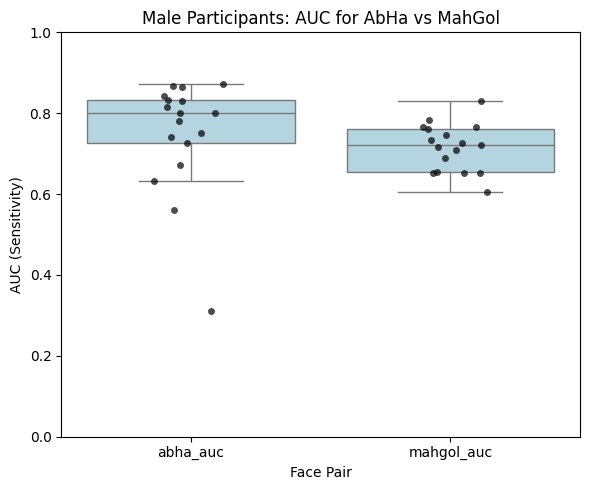

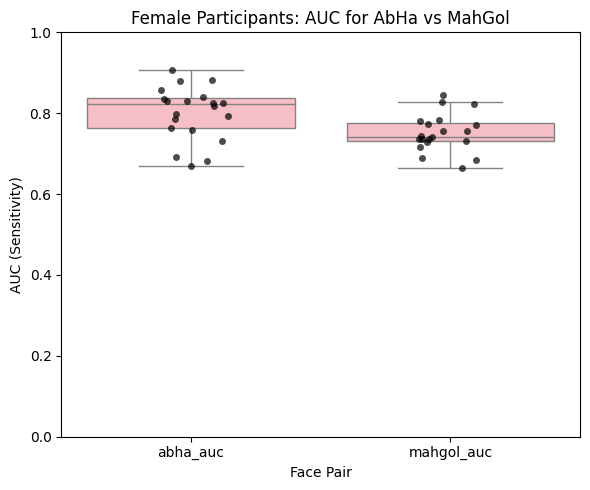

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_19348\2021764002.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=male_data, x='pair', y='auc', join=False, color='black', ci='sd')
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_19348\2021764002.py:32: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=male_data, x='pair', y='auc', join=False, color='black', ci='sd')


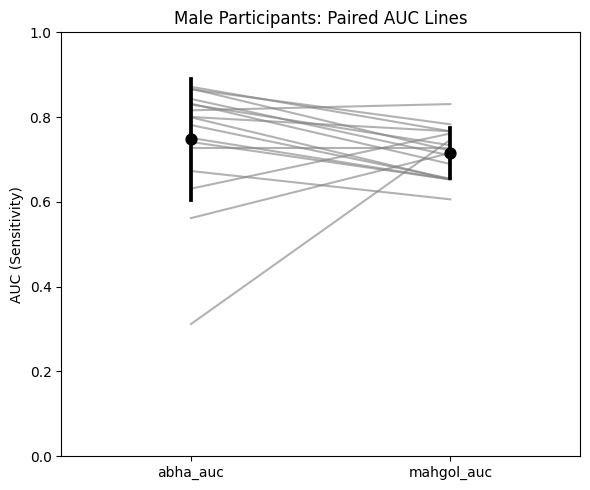

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_19348\2021764002.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=female_data, x='pair', y='auc', join=False, color='black', ci='sd')
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_19348\2021764002.py:43: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=female_data, x='pair', y='auc', join=False, color='black', ci='sd')


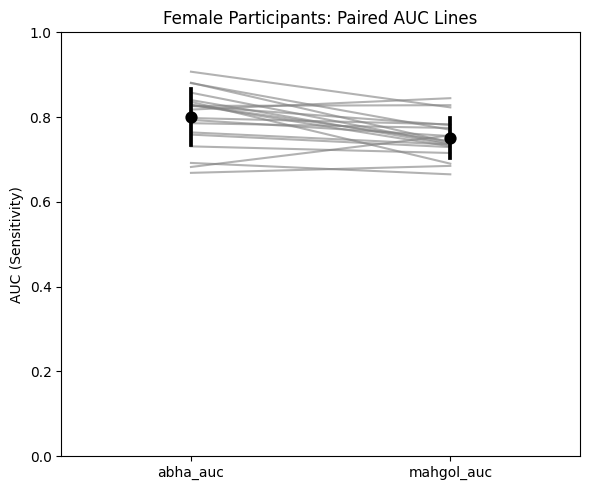

In [17]:
long_auc_df = pd.melt(
    auc1,
    id_vars=['subject_id', 'sex'],
    value_vars=['abha_auc', 'mahgol_auc'],
    var_name='pair',
    value_name='auc'
)
male_data = long_auc_df[long_auc_df['sex'] == 'M']
female_data = long_auc_df[long_auc_df['sex'] == 'F']
plt.figure(figsize=(6, 5))
sns.boxplot(data=male_data, x='pair', y='auc', showfliers=False, color='lightblue')
sns.stripplot(data=male_data, x='pair', y='auc', color='black', jitter=0.15, alpha=0.7)
plt.title('Male Participants: AUC for AbHa vs MahGol')
plt.ylabel('AUC (Sensitivity)')
plt.xlabel('Face Pair')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 5))
sns.boxplot(data=female_data, x='pair', y='auc', showfliers=False, color='lightpink')
sns.stripplot(data=female_data, x='pair', y='auc', color='black', jitter=0.15, alpha=0.7)
plt.title('Female Participants: AUC for AbHa vs MahGol')
plt.ylabel('AUC (Sensitivity)')
plt.xlabel('Face Pair')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 5))
for sid in male_data['subject_id'].unique():
    d = male_data[male_data['subject_id'] == sid]
    plt.plot(d['pair'], d['auc'], color='gray', alpha=0.6)
sns.pointplot(data=male_data, x='pair', y='auc', join=False, color='black', ci='sd')
plt.title('Male Participants: Paired AUC Lines')
plt.ylabel('AUC (Sensitivity)')
plt.xlabel('')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 5))
for sid in female_data['subject_id'].unique():
    d = female_data[female_data['subject_id'] == sid]
    plt.plot(d['pair'], d['auc'], color='gray', alpha=0.6)
sns.pointplot(data=female_data, x='pair', y='auc', join=False, color='black', ci='sd')
plt.title('Female Participants: Paired AUC Lines')
plt.ylabel('AUC (Sensitivity)')
plt.xlabel('')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Third hypothesis:

In [18]:
def compute_auc_from_df(df):
    df['correct'] = df['srespChoice'] == df['rCueName']
    x = df['levelFace']
    y = df['correct'].astype(int)
    if len(np.unique(y)) == 1:
        return 0.5
    auc = roc_auc_score(y, x)
    return auc
all_rows = []
for subj in subject[1:]:
    aucs = {}
    aucs['subjectId'] = subj['subjectId'].iloc[0]
    for key in ['AbHa', 'MahGol']:
        for freq in ['LF', 'IF', 'HF']:
            for hand in ['Left', 'Right']:
                subset = subj[(subj['trialKeys'] == key) & (subj['levelFreq'] == freq) & (subj['Hand'] == hand)]
                auc = compute_auc_from_df(subset)
                aucs[f'{key.lower()}_{freq.lower()}_{hand.lower()}'] = auc
    all_rows.append(aucs)
auc2 = pd.DataFrame(all_rows)
auc2.head()

C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_19348\5026270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct'] = df['srespChoice'] == df['rCueName']
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_19348\5026270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct'] = df['srespChoice'] == df['rCueName']
C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_19348\5026270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

subjectId  abha_lf_left  abha_lf_right  abha_if_left  abha_if_right  \
0      sub1      0.076774       0.093750      0.055556       0.028205   
1      sub2      0.391156       0.294872      0.563241       0.656098   
2      sub3      0.969987       0.957143      0.989583       0.980204   
3      sub4      0.097419       0.101707      0.120553       0.093583   
4      sub5      0.528623       0.625000      0.898467       0.984848   

   abha_hf_left  abha_hf_right  mahgol_lf_left  mahgol_lf_right  \
0      0.804762       0.593750        0.119048         0.087500   
1      0.630612       0.520645        0.183673         0.234355   
2      0.793878       0.851220        0.878033         0.980204   
3      0.082888       0.141026        0.377778         0.152174   
4      0.500000       0.020833        0.840645         0.766667   

   mahgol_if_left  mahgol_if_right  mahgol_hf_left  mahgol_hf_right  
0        0.025161         0.050447        0.795875         0.777526  
1        0.941026         0.935374        0.625178         0.555556  
2        0.981283         0.990421        0.533333         0.742424  
3        0.216312         0.072193        0.426219         0.356410  
4        0.062500         0.038462        0.562500         0.708333

In [19]:
lf_ = [wilcoxon(auc2['abha_lf_left'], auc2['abha_lf_right']).pvalue, wilcoxon(auc2['mahgol_lf_left'], auc2['mahgol_lf_right']).pvalue] 
print("P value for lf freq:", lf_[0], lf_[1])

P value for lf freq: 0.6155919205411919 0.3964651001515449


In [20]:
if_ = [wilcoxon(auc2['abha_if_left'], auc2['abha_if_right']).pvalue, wilcoxon(auc2['mahgol_if_left'], auc2['mahgol_if_right']).pvalue] 
print("P value for if freq:", if_[0], if_[1])

P value for if freq: 0.4638921673540608 0.3774806885913661


In [21]:
hf_ = [wilcoxon(auc2['abha_hf_left'], auc2['abha_hf_right']).pvalue, wilcoxon(auc2['mahgol_hf_left'], auc2['mahgol_hf_right']).pvalue] 
print("P value for hf freq:", hf_[0], hf_[1])

P value for hf freq: 0.4551378802789259 0.6565873849904165


In [22]:
auc_long = pd.melt(
    auc2,
    id_vars=['subjectId'],
    value_vars=auc2.columns[1:],
    var_name='condition',
    value_name='auc'
)
auc_long[['pair', 'freq', 'side']] = auc_long['condition'].str.extract(r'(\w+)_(\w+)_([a-z]+)')

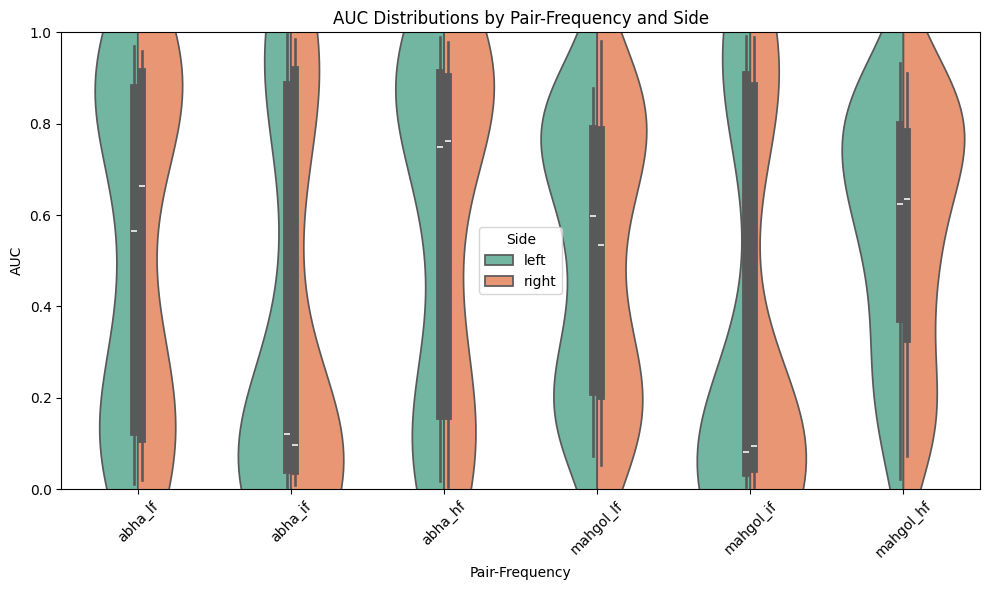

In [23]:
auc_long['pair_freq'] = auc_long['pair'] + '_' + auc_long['freq']
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=auc_long,
    x='pair_freq',
    y='auc',
    hue='side',
    split=True,
    inner='box',
    palette='Set2'
)
plt.title('AUC Distributions by Pair-Frequency and Side')
plt.ylabel('AUC')
plt.xlabel('Pair-Frequency')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Side')
plt.tight_layout()
plt.show()

4th:

In [24]:
def compute_auc_from_df(df):
    correct = (df['srespChoice'] == df['rCueName']).astype(int)
    if len(np.unique(correct)) == 1:
        return 0.5
    return roc_auc_score(correct, df['levelFace'])
results = []
for i in range(1, len(subject)):
    subj_df = subject[i]
    subj_id = subj_df['subjectId'].iloc[0]
    dom_hand = 'Right' if sub_info.iloc[i-1]['dom'] == 'R' else 'Left'
    row = {'subjectId': subj_id}
    for pair in ['AbHa', 'MahGol']:
        for freq in ['LF', 'IF', 'HF']:
            subset_dom = subj_df[
                (subj_df['trialKeys'] == pair) &
                (subj_df['levelFreq'] == freq) &
                (subj_df['Hand'] == dom_hand)
            ]
            subset_nondom = subj_df[
                (subj_df['trialKeys'] == pair) &
                (subj_df['levelFreq'] == freq) &
                (subj_df['Hand'] != dom_hand)
            ]
            row[f"{pair.lower()}_{freq.lower()}_dom"] = compute_auc_from_df(subset_dom)
            row[f"{pair.lower()}_{freq.lower()}_nondom"] = compute_auc_from_df(subset_nondom)
    results.append(row)
auc_4 = pd.DataFrame(results)

In [25]:
auc_4.head()

subjectId  abha_lf_dom  abha_lf_nondom  abha_if_dom  abha_if_nondom  \
0      sub1     0.093750        0.076774     0.028205        0.055556   
1      sub2     0.294872        0.391156     0.656098        0.563241   
2      sub3     0.957143        0.969987     0.980204        0.989583   
3      sub4     0.101707        0.097419     0.093583        0.120553   
4      sub5     0.625000        0.528623     0.984848        0.898467   

   abha_hf_dom  abha_hf_nondom  mahgol_lf_dom  mahgol_lf_nondom  \
0     0.593750        0.804762       0.087500          0.119048   
1     0.520645        0.630612       0.234355          0.183673   
2     0.851220        0.793878       0.980204          0.878033   
3     0.141026        0.082888       0.152174          0.377778   
4     0.020833        0.500000       0.766667          0.840645   

   mahgol_if_dom  mahgol_if_nondom  mahgol_hf_dom  mahgol_hf_nondom  
0       0.050447          0.025161       0.777526          0.795875  
1       0.935374          0.941026       0.555556          0.625178  
2       0.990421          0.981283       0.742424          0.533333  
3       0.072193          0.216312       0.356410          0.426219  
4       0.038462          0.062500       0.708333          0.562500

In [26]:
lf_ = [wilcoxon(auc_4['abha_lf_dom'], auc_4['abha_lf_nondom']).pvalue, wilcoxon(auc_4['mahgol_lf_dom'], auc_4['mahgol_lf_nondom']).pvalue] 
print("P value for lf freq:", lf_[0], lf_[1])

P value for lf freq: 0.4379049589188071 0.6565873849904165


In [27]:
if_ = [wilcoxon(auc_4['abha_if_dom'], auc_4['abha_if_nondom']).pvalue, wilcoxon(auc_4['mahgol_if_dom'], auc_4['mahgol_if_nondom']).pvalue] 
print("P value for if freq:", if_[0], if_[1])

P value for if freq: 0.4045627222803887 0.5613604257922649


In [28]:
hf_ = [wilcoxon(auc_4['abha_hf_dom'], auc_4['abha_hf_nondom']).pvalue, wilcoxon(auc_4['mahgol_hf_dom'], auc_4['mahgol_hf_nondom']).pvalue] 
print("P value for hf freq:", hf_[0], hf_[1])

P value for hf freq: 0.3425032254308462 0.42942789146036375


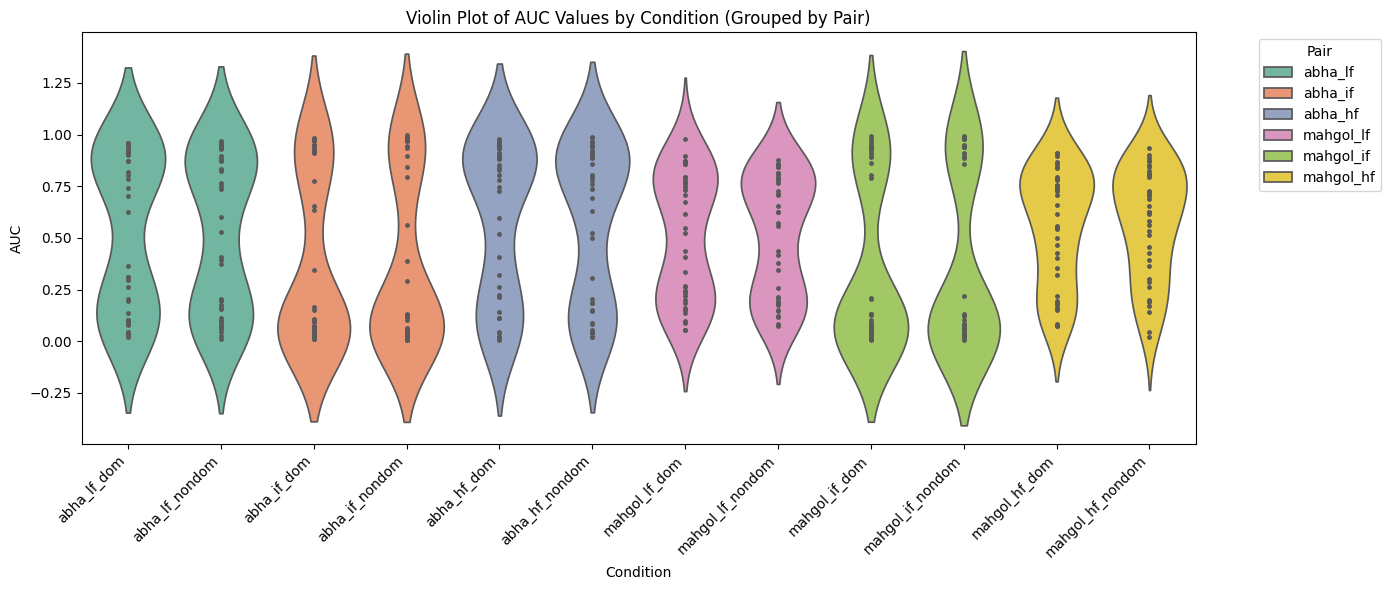

In [29]:
auc_melted = auc_4.melt(id_vars="subjectId", var_name="Condition", value_name="AUC")
auc_melted['Pair'] = auc_melted['Condition'].apply(lambda x: '_'.join(x.split('_')[:2]))
unique_pairs = auc_melted['Pair'].unique()
palette = sns.color_palette("Set2", n_colors=len(unique_pairs))
pair_palette = dict(zip(unique_pairs, palette))
plt.figure(figsize=(14, 6))
sns.violinplot(x="Condition", y="AUC", data=auc_melted, hue="Pair", palette=pair_palette, dodge=False, inner="point")
plt.xticks(rotation=45, ha='right')
plt.title("Violin Plot of AUC Values by Condition (Grouped by Pair)")
plt.legend(title="Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

last hypo:

In [30]:
results = []
for i in range(1, len(subject)):
    df_sub = subject[i]
    sex = sub_info.iloc[i-1]['sex']
    abha_df = df_sub[df_sub['trialKeys'] == 'AbHa']
    labels_abha = (abha_df['levelFace'] > 0).astype(int)
    preds_abha = (abha_df['srespChoice'] == 'Hasan').astype(int)
    if len(np.unique(labels_abha)) < 2 or len(np.unique(preds_abha)) < 2:
        abha_auc = 0.5
    else:
        abha_auc = roc_auc_score(labels_abha, preds_abha)
    mahgol_df = df_sub[df_sub['trialKeys'] == 'MahGol']
    labels_mahgol = (mahgol_df['levelFace'] > 0).astype(int)
    preds_mahgol = (mahgol_df['srespChoice'] == 'Goli').astype(int)
    if len(np.unique(labels_mahgol)) < 2 or len(np.unique(preds_mahgol)) < 2:
        mahgol_auc = 0.5
    else:
        mahgol_auc = roc_auc_score(labels_mahgol, preds_mahgol)
    results.append({
        'subjectId': df_sub['subjectId'].iloc[0],
        'sex': sex,
        'abha': abha_auc,
        'mahgol': mahgol_auc
    })
auc_5 = pd.DataFrame(results)

In [31]:
auc_5.tail()

subjectId sex      abha    mahgol
33     sub34   M  0.750868  0.652778
34     sub35   F  0.817708  0.844618
35     sub36   F  0.880208  0.769965
36     sub37   F  0.907118  0.822917
37     sub38   F  0.691840  0.664931

In [32]:
abha_p = mannwhitneyu(auc_5[auc_5['sex'] == 'M']['abha'], auc_5[auc_5['sex'] == 'F']['abha'])
print("P value for abha:", abha_p.pvalue)

P value for abha: 0.36857197390741314


In [33]:
mahgol_p = mannwhitneyu(auc_5[auc_5['sex'] == 'M']['mahgol'], auc_5[auc_5['sex'] == 'F']['mahgol'])
print("P value for mahgol:", mahgol_p.pvalue)
print("median for females mahgol:", auc_5[auc_5['sex'] == 'F']['mahgol'].median())
print("median for males mahgol:", auc_5[auc_5['sex'] == 'M']['mahgol'].median())
print("median for females mahgol:", auc_5[auc_5['sex'] == 'F']['mahgol'].median())
print("median for males mahgol:", auc_5[auc_5['sex'] == 'M']['mahgol'].median())

P value for mahgol: 0.058777467675843416
median for females mahgol: 0.7417534722222222
median for males mahgol: 0.720486111111111
median for females mahgol: 0.7417534722222222
median for males mahgol: 0.720486111111111


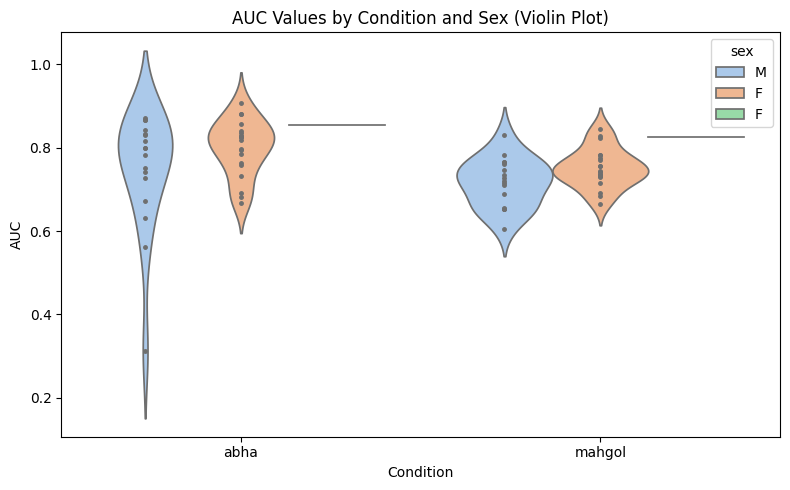

In [34]:
auc_5_melted = auc_5.melt(id_vars=["subjectId", "sex"], var_name="Condition", value_name="AUC")
plt.figure(figsize=(8, 5))
sns.violinplot(x="Condition", y="AUC", hue="sex", data=auc_5_melted, palette="pastel", inner="point", dodge=True)
plt.title("AUC Values by Condition and Sex (Violin Plot)")
plt.tight_layout()
plt.show()